# Разарботка моделей предсказания поведения персонала для HR-компании "Работа с заботой"

## Введение

<font color='navy'><b><u>Целевая задача Заказчика</b></u><i> - избежание финансовых потерь и оттока сотрудников</i><br>

<Font color='navy'><b><i><u>Цель исследования </b></i></u>- разработка механизмов оптимизации управления персоналом

<Font color='navy'><b><i><u>Задачи исследования</b></i></u><br>&nbsp;&nbsp;&nbsp;1. построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных Заказчика<br>&nbsp;&nbsp;&nbsp;2. построить модель, которая сможет на основе данных Заказчика предсказать возможность увольнения сотрудника из компании<br>

<Font color='navy'><b><i><u>План работы</b></i></u><br>
<Font color='navy'>1. загрузка, обзор и предобработка данных<br>
<Font color='navy'>2. анализ данных<br>
<Font color='navy'>3. определение модели, наилучшим образом пронозирующей уровень удовлетворённости сотрудника<br>
<Font color='navy'>4. определение модели, наилучшим образом пронозирующей вероятность увольнения сотрудника<br>

## Загрузка и обзор днных

### Загрузка библиотек

In [9]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import shap
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.simplefilter("ignore")

# импорт модулей для разделения данных и создания моделей МО
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import svm
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.dummy import DummyClassifier, DummyRegressor

# загружаем необходимые инструменты для создания пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# импорт модулей для масштабирования и кодирования
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   RobustScaler)
 
# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импорт модулей для расчета метрик
from sklearn.metrics import (make_scorer, \
                             roc_auc_score, \
                             confusion_matrix)

# импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# проверка типа данных
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# Снимем ограничения на вывод данных в pandas-таблице
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format


### Загрузка и обзор данных

In [11]:
# функция для обзора данных
def display_df_info(data):
    display(data.head(5))
    print('-'*100)
    data.info()
    print('-'*100)
    print('Количество столбцов - {}, количество записей - {}'.format(data.shape[1], data.shape[0]))
   
    dupl = data.duplicated().sum()
    if dupl != 0:
        print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / data.shape[0]))
    else:
        print('Дубликаты записей не выявлены')
    
    if data.isnull().sum().sum() != 0:
            try:
                (data.isna().mean()*100).to_frame() \
                .rename(columns = {0:'space'}) \
                .query('space > 0') \
                .sort_values(by = 'space', ascending = True) \
                .plot(kind = 'barh', figsize = (8, 2), legend = False, fontsize = 7, color='royalblue', \
                      title ='Пропущенные значения, %', \
                      xlabel = 'Процент пропусков', \
                      ylabel='Столбцы с пропусками', \
                      grid=True, style='-',)
                plt.show();    
            except:
                print('Пропусков данных нет')
    else:
        print('Пропусков данных нет')

In [12]:
# загрузим предоставленные датасеты
## 1. тернировочная выборка входные признаки и целевой признак для первой задачи
train_satisfaction = pd.read_csv('C:\\Data_Science\\projects\\HR_analytics\\train_job_satisfaction_rate.csv', sep=',', decimal=".")
## 2. тестовая выборка входные признаки
test_features = pd.read_csv('C:\\Data_Science\\projects\\HR_analytics\\test_features.csv', \
                            sep=',', decimal=".")
## 3. тестовая выборка целевой признак для первой задачи
test_target_satisfaction = pd.read_csv('C:\\Data_Science\\projects\\HR_analytics\\test_target_job_satisfaction_rate.csv', \
                                                sep=',', decimal=".", thousands=',')
## 4. тернировочная выборка целевой признак для второй задачи
train_quit = pd.read_csv('C:\\Data_Science\\projects\\HR_analytics\\train_quit.csv', sep=',', decimal='.')
## 5. тестовая выборка целевой признак для второй задачи
test_target_quit = pd.read_csv('C:\\Data_Science\\projects\\HR_analytics\\test_target_quit.csv', \
                                                sep=',', decimal=".")

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
----------------------------------------------------------------------------------------------------
Кол

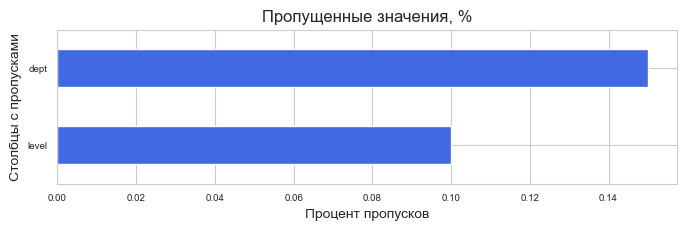

In [13]:
display_df_info(train_satisfaction)

<Font color='navy'>Датасет <b>`train_satisfaction`</b> содержит 10 колонок 4000 записей тенировочной выборки данных о персонале<br>
<Font color='navy'>- `id` — уникальный идентификатор сотрудника, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'><b>- колнки входных признаков:</b><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `dept` — отдел, в котором работает сотрудник, тип данных object - соответствует описанию, есть 6 пропущенных значения<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `level` — уровень занимаемой должности, тип данных object - соответствует описанию, есть 4 пропущенных значения<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `work_load` — уровень загруженности сотрудника, тип данных object - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `employement_years` — длительность работы в компании (в годах), тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `last_year_promo` — показывает, было ли повышение за последний год , тип данных object - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год , тип данных object - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `salary` — ежемесячная зарплата сотрудника, тип данных int - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>- `job_satisfaction_rate` — уровень удовлeтворённости сотрудника работой в компании, <b>целевой признак для первой задачи</b>, тип данных object - <i><u><b>соответствует описанию</b></i></u>, пропусков данных нет<br>

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 9, количество записей - 2000
Дубликаты записей не выявлен

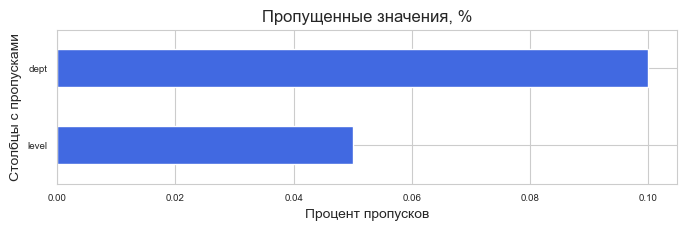

In [15]:
display_df_info(test_features)

<Font color='navy'>Датасет <b>`test_features`</b> тестовый набор данных о персонале, содержит 2000 записей с идентичным перечнем колонок - входных признаков. <br>Пропуски данных также, как и в тренировочной выборки присутсвуют в колонках<br>
<Font color='navy'>- `dept` — отдел, в котором работает сотрудник, 2 пропущенных значения<br>
<Font color='navy'>- `level` — уровень занимаемой должности, 1 пропущенное значения<br>

In [17]:
display_df_info(test_target_satisfaction)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 2, количество записей - 2000
Дубликаты записей не выявлены
Пропусков данных нет


<Font color='navy'>Датасет <b>`test_target_satisfaction`</b> тестовый набор данных <b>целевого признака для первой задачи</b>, содержит 2000 записей. <br>Пропусков в данных нет<br>Тип данных в колонке `job_satisfaction_rate` object - <i><u><b>соответствует описанию<br>

In [19]:
display_df_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 10, к

<Font color='navy'>Датасет <b>`train_quit`</b> содержит 10 колонок 4000 записей тренировочной выборки данных о персонале с идентичным перечнем колонок-входных признаков, что и датасет <b>`train_job_satisfaction_rate`</b>, а такжке колонокй целевого признака для второй задачи<br>Пропусков данных нет<br>
<Font color='navy'>Колонка `quit` — увольнение сотрудника из компании, <b>целевой признак для второй задачи</b>, тип данных object - соответствует описанию<br>

In [21]:
display_df_info(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 2, количество записей - 2000
Дубликаты записей не выявлены
Пропусков данных нет


<Font color='navy'>Датасет <b>`test_target_quit`</b> тестовый набор данных <b>целевого признака для второй задачи</b>, содержит 2000 записей. <br>Пропусков в данных нет<br>Тип данных в колонке `quit` object - соответствует описанию<br>

### Предобработка данных

<font color='navy'> <u><i>Из информации о данных видно</u>,</i> что </br>
<font color='navy'>1. во всех датасетах наименование колонок корректное</br>
<font color='navy'>2. во всех датасетах нет явных дубликатов данных</br>
<font color='navy'>3. в тренировочных и тестовых данных есть пропуск информации по входящим признакам: `dept` (6 и 2 соответственно) и `level`(4 и 1 соответственно)</br>

In [25]:
#посмотрим на пропущенные данные в тренировочной выборке
train_satisfaction[train_satisfaction['dept'].isnull() | train_satisfaction['level'].isnull()].sort_values(by='dept')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


<font color='navy'>Пропуски данных в тренировочной выборке<br>- по колонке `dept` относятся к сотрудникам уровня junior, работающим в основном более 3х лет, без нарушений и без продвижения.<br>- по колонке `level` относятся к сотрудникам отедла sales, работающим 1 год, со средней загрузкой без нарушений и без продвижения.<br>Предполжу, что пропуски данных в обоих случаях были связаны с нежелением сотрудников указывать в анкете свой уровень или должность.<br><i>Воздержусь от удаления данных, а в дальнейшем, при подготовке данных к модели, необходимо будет использовать SimpleImputer заменив пропуски на моду

In [27]:
#посмотрим на пропущенные данные в тестовой выборке
test_features[test_features['dept'].isnull() | test_features['level'].isnull()].sort_values(by='dept')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


<font color='navy'>Пропуски данных в тестовой выборке<br>- по колонке `dept` относятся к сотрудникам уровня junior, работающим 1 год, без нарушений и без продвижения.<br>- по колонке `level` относится к сотруднику отедла sales, работающему 1 год, со средней загрузкой без нарушений и без продвижения.<br>Как и в случае с тренировочной выборкой, предполжу, что пропуски данных в обоих случаях были связаны с нежеланием сотрудников указывать в анкете свой уровень или должность.<br><i>Так же как и в тренировочной выборке - воздержусь от удаления данных, а в дальнейшем, при подготовке данных к модели, буду использовать SimpleImputer заменив пропуски на моду

In [29]:
# посмотрим на уникальные значения в текстовых колонках
print('Уникальные значения текстовых колонок в датасете train_satisfaction')
for col in train_satisfaction.select_dtypes(exclude='number').columns.tolist():
    print('   - колонка', col, train_satisfaction[col].unique())
print('-'*100)
print('Уникальные значения текстовых колонок в датасете train_quit')
for col in train_quit.select_dtypes(exclude='number').columns.tolist():
    print('   - колонка', col, train_quit[col].unique())
print('-'*100)
print('Уникальные значения текстовых колонок в датасете test_features')
for col in test_features.select_dtypes(exclude='number').columns.tolist():
    print('   - колонка', col, test_features[col].unique())
print('-'*100)

Уникальные значения текстовых колонок в датасете train_satisfaction
   - колонка dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
   - колонка level ['junior' 'middle' 'sinior' nan]
   - колонка workload ['medium' 'high' 'low']
   - колонка last_year_promo ['no' 'yes']
   - колонка last_year_violations ['no' 'yes']
----------------------------------------------------------------------------------------------------
Уникальные значения текстовых колонок в датасете train_quit
   - колонка dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
   - колонка level ['middle' 'junior' 'sinior']
   - колонка workload ['high' 'medium' 'low']
   - колонка last_year_promo ['no' 'yes']
   - колонка last_year_violations ['no' 'yes']
   - колонка quit ['no' 'yes']
----------------------------------------------------------------------------------------------------
Уникальные значения текстовых колонок в датасете test_features
   - колонка dept ['marketing' 'hr' 'sales' 'purchasing' 'te

<font color='navy'>В датасете test_features в колонке `dept`и колонке `workload` есть пустые значения. Посмотрим на них более детально

In [31]:
test_features.query('dept == " " or workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


<font color='navy'> Обнаруженные дополнительные пропуски данных в `workload` и `dept` в дальнейшем будут обработаны в ходе применение SimpleImputer ко всем строковым данным, что позволит избежать проблем на этапе выбора модели

### Резюме обзора и пердобработки данных

<font color='Darkblue'><b><u>A.</b> Для исследования предоставлено 5 датасетов</u><br> &nbsp;&nbsp;&nbsp;<b>1) Датасет `train_satisfaction`</b> содержит 10 колонок 4000 записей тенировочной выборки данных о персонале<br> &nbsp;&nbsp;&nbsp;<b>2) Датасет `test_features`</b> тестовый набор данных о персонале, содержит 2000 записей<br> &nbsp;&nbsp;&nbsp;<b>3) Датасет `test_target_satisfaction`</b> тестовый набор данных содержит 2 колонки 2000 записей.<br> &nbsp;&nbsp;&nbsp;<b>4) Датасет `train_quit`</b> содержит 10 колонок 4000 записей<br> &nbsp;&nbsp;&nbsp;<b>5) Датасет `test_target_quit`</b> содержит 2 колонки 2000 записей<br>
<Font color='navy'>Все датасеты содержат - `id` — уникальный идентификатор сотрудника<br>
<Font color='navy'>Датасеты `train_satisfaction`, `train_quit` и `test_features` - содержат колонки <b>входных признаков:</b><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `dept` — отдел, в котором работает сотрудник<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `level` — уровень занимаемой должности<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `work_load` — уровень загруженности сотрудника<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `employement_years` — длительность работы в компании (в годах)<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `last_year_promo` — показывает, было ли повышение за последний год<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `salary` — ежемесячная зарплата сотрудника<br>
<Font color='navy'>Датасеты `train_satisfaction` и `test_target_satisfaction` содержат колонки <b>целевого признака для первой задачи</b> - `job_satisfaction_rate` — уровень удовлeтворённости сотрудника работой в компании<br>
<Font color='navy'>Датасеты `train_quit` и `test_target_quit` содержат колонки <b>целевого признака для второй задачи</b> - `quit` — увольнение сотрудника из компании сотрудника из компании<br>
<font color='Darkblue'><u><b>B.</b> В рамках предподготовки данных</u><br>&nbsp;&nbsp;&nbsp; - изменен тип данных в колонке `job_satisfaction_rate` для тестовой и тренировочной выборок <br>&nbsp;&nbsp;&nbsp; - определены, но не удалены пропуски данных в колонках `dept`, `level` и `workload` - которые в дальнейшем при подготовке данных для модели будут заменены SimpleImputer на моду<br>

## Анализ данных

<Font color='navy'><i>Для удобства проведения анализ предоставленных данных объединим датасеты

In [37]:
# Перед объединением проверим совпадение id сотрудников для первой и второй задач по выборкам
compair_train = {'satisf_tr': train_satisfaction['id'].sort_values().to_list(), 
                 'quit_tr': train_quit['id'].sort_values().to_list()}
df_1 = pd.DataFrame(compair_train) 
if df_1['satisf_tr'].equals(df_1['quit_tr']):
    print ('ID в тренировочной выборке для первой и второй задач совпадают')
else:
    print ('ID в тренировочной выборке для первой и второй задач НЕ совпадают')
print('-'*100)

compair_test_satisf = {'satisf_test_features': test_features['id'].sort_values().to_list(), 
                       'satisf_test_target': test_target_satisfaction['id'].sort_values().to_list()}
df_2 = pd.DataFrame(compair_test_satisf)
if df_2['satisf_test_features'].equals(df_2['satisf_test_target']):
    print ('ID в тестовой выборке и ID в целевом признаке для первой задачи совпадают')
else:
    print ('ID в тестовой выборке и ID в целевом признаке для первой задачи НЕ совпадают')
print('-'*100)

compair_test_quit = {'quit_test_features': test_features['id'].sort_values().to_list(), 
                       'quit_test_target': test_target_quit['id'].sort_values().to_list()}
df_3 = pd.DataFrame(compair_test_quit)
if df_3['quit_test_features'].equals(df_3['quit_test_target']):
    print ('ID в тестовой выборке и ID в целевом признаке для второй задачи совпадают')
else:
    print ('ID в тестовой выборке и ID в целевом признаке для второй задачи НЕ совпадают')
print('-'*100)


ID в тренировочной выборке для первой и второй задач НЕ совпадают
----------------------------------------------------------------------------------------------------
ID в тестовой выборке и ID в целевом признаке для первой задачи совпадают
----------------------------------------------------------------------------------------------------
ID в тестовой выборке и ID в целевом признаке для второй задачи совпадают
----------------------------------------------------------------------------------------------------


<Font color='navy'><i>Из выше приведенных результатов сравнения перечней ID сотрудников следтует, что сотрудники, отобранные для тренировочной выборки первой и второй задач, были разные, и, поэтому, несмотря на совпадение ID сотрудников тестовой выбобрки для обеих задач, <b>объединять для анализа данные первой и второй задач нельзя</b>. Поэтому в целях анализа данных рассмотрим тестовую и тренировочную выборки отдельно и объединенные данные для первой задачи, и тоже самое для второй задачи. Общий анализ сводных данных проведем только на объединенных тестовых данных.

### Определим функции для визуализации данных

#### Визуализация данных непрерывного количественного признака (без структуры по классам)

In [41]:
def continuous_data_plot(df, column):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'распределение признака "{column}"', color = 'navy')
    sns.histplot(data=df, x=column, facecolor = 'lightsteelblue', \
                 color='navy',edgecolor='navy', \
                 stat='density', common_norm=False, kde=True)
    median_value = df[column].median()
    mean_value = df[column].mean()
    plt.axvline(median_value, color='maroon', linestyle='--', label=f'Median: {median_value:.2f}')
    plt.axvline(mean_value, color='gold', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.xlabel(f'значения "{column}"', color = 'navy')
    plt.xticks(color='navy', fontsize=7)
    plt.ylabel('плотность распределения', color = 'navy')
    plt.yticks(color='navy', fontsize=7)
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, y=column, color='lightsteelblue', fill=True, \
                gap=.1, width=.75, linecolor='navy')
    plt.title(f'признак "{column}"',  fontsize=12, color='navy')
    plt.ylabel(f'количество "{column}"', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')
    
    plt.show()

#### Визуализация данных дискретного количественного признака (без структуры по классам)

In [43]:
def descrete_data_plot(df, column):
    plt.title(f'распределение признака "{column}"', color = 'navy')
    sns.countplot(x = column, data=df, \
                  facecolor = 'lightsteelblue', color='navy', edgecolor='navy', \
                  stat="percent")
    plt.xlabel(column, color = 'navy')
    plt.xticks(color='navy', fontsize=7)
    plt.ylabel('доля сотрудников', color = 'navy')
    plt.yticks(color='navy', fontsize=7)
    plt.show();

#### Визуализация данных категориального признака (без структуры по классам)

In [45]:
def cat_data_plot(df, col, ncols, naxes):
    df = df.loc[df.loc[:, col] != " "]
    plt.subplot(1, ncols, naxes)
    plt.title(f'Распределение сотрудников\nпо "{col}"', color='navy', fontsize=12)
    plt.pie(x=df[col].value_counts(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth': 2, 'edgecolor':'whitesmoke'}, shadow=True, \
            textprops={'fontsize': 12, 'color': 'darkblue'},
            autopct='%1.1f%%',
            labels=[x for x in list(df[col].unique()) if str(x) != 'nan'], 
            colors=sns.color_palette('deep'))

#### Визуализация данных непрерывного количественного признака (c учетом структуры по классам)

In [47]:
# соформируем функцию для визуализации распределения непрерывных количественных признаокв 
# в разрезе категорий целевого признака - статус увольнения (yes - уволен, no - работает)
def continuous_data_plot_2(df, col):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=col, hue='quit', palette ={'yes': 'navy', 'no': 'cornflowerblue'}, \
                 edgecolor = 'navy', \
                 stat='density', common_norm=False, kde=True)
    plt.title(f'Гистограмма распределения \nдля "{col}" по статусу увольнения',  fontsize=12, color='navy')
    plt.xlabel(col, fontsize=10, color='navy')
    plt.ylabel('плотность распределения', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='quit', y=col, hue='quit', 
                palette ={'yes': 'lightsteelblue', 'no': 'cornflowerblue'}, fill=True, gap=.1, width=.75, \
                linecolor='navy')
    plt.title(f'Диаграмма размаха \nдля "{col}" по статусу увольнения',  fontsize=12, color='navy')
    plt.ylabel(col, fontsize=10, color='navy')
    plt.xlabel('quit', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')
    plt.show()

#### Визуализация данных дискретного количественного признака (с учетом структуры по классам)

In [49]:
def descrete_data_plot_2(df, column):
    plt.title(f'распределение признака "{column}"', color = 'navy')
    sns.countplot(x = column, data=df, \
                  palette ={'no': 'royalblue', 'yes': 'cornflowerblue'}, 
                  hue='quit', stat="percent")
    plt.xlabel('column', color = 'navy')
    plt.xticks(rotation=45, color='navy', fontsize=7)
    plt.ylabel('процент сотрудников', color = 'navy')
    plt.legend(fontsize = 8, \
               bbox_to_anchor= (1, 1), \
               title="статус \nувольнения", \
               title_fontsize = 9)
    plt.show();

#### Визуализация данных категориального признака (с учетом структуры по классам)

In [51]:
# соформируем функцию для визуализации распределения категорийных признаокв 
# в разрезе категорий целевого признака
def cat_data_plot_2(df, col):
    df = df.loc[df.loc[:, col] != " "]
    labels = [x for x in list(df[col].unique()) if str(x) != 'nan']
    values_a = df[df['quit'] == 'yes'].groupby(col)['id'].count()
    values_b = df[df['quit'] == 'no'].groupby(col)['id'].count()
    total_a = sum(values_a)
    total_b = sum(values_b)
    labels_a = [f"{n} (value - {v:.1f}, \nshare - {v/total_a:.1%})" for n,v in zip(labels, values_a)]
    labels_b = [f"{n} (value - {v:.1f}, \nshare - {v/total_b:.1%})" for n,v in zip(labels, values_b)]
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.pie(values_a, colors=sns.color_palette('Blues_r'), \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
    plt.title(f'Распределение "{col}" \nдля уволившихся сотрудников',  fontsize=12, color='navy')
    plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels_a, fontsize=9)
    plt.subplot(1, 2, 2)
    plt.pie(values_b, colors=sns.color_palette('vlag'), \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
    plt.title(f'Распределение "{col}" \nдля работающих в компании сотрудников',  fontsize=12, color='navy')
    plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels_b, fontsize=9)
    plt.show()

### Анализ данных для первой задачи

In [53]:
# Определеим перечень колонок, относящихся к количественным (непрерывным и дискретным) и категориальным данным
# непрерывные количесвтенные данные - зарплата и уровень удовлетворенности работой (целевой признак)
case_1_continuous_cols = ['job_satisfaction_rate', 'salary']
# дискреные количесвтенные данные - количество отработанных в компании лет и оценка руководителя
case_1_descrete_cols = ['employment_years', 'supervisor_evaluation']
# категориальные данные
case_1_cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [54]:
# Объединим входные и целевой признаки тестовой выборки для первой задачи
test_satisfaction = test_features.merge(test_target_satisfaction, on='id', how='left')

In [55]:
# Объединим тренировочную и тестовую выборки для первой задачи
case_1 = pd.concat([train_satisfaction, test_satisfaction], axis=0)

#### Анализ данных тренировочной выборки

In [57]:
display(train_satisfaction.drop('id', axis=1).describe(percentiles=[.125, .5, .875]))
train_satisfaction.describe(include='object')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,"4,000.00","4,000.00","4,000.00","4,000.00"
mean,3.72,3.48,"33,926.70",0.53
std,2.54,1.01,"14,900.70",0.23
min,1.00,1.00,"12,000.00",0.03
12.5%,1.00,2.00,"19,200.00",0.24
50%,3.00,4.00,"30,000.00",0.56
87.5%,7.00,5.00,"52,800.00",0.80
max,10.00,5.00,"98,400.00",1.00


,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


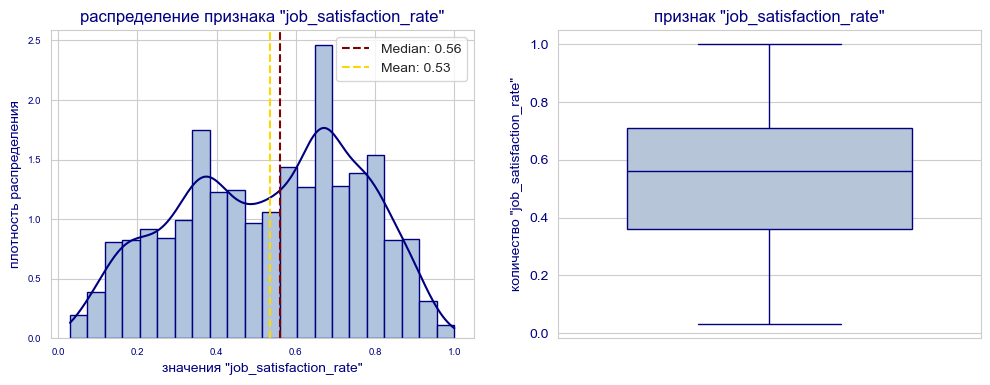

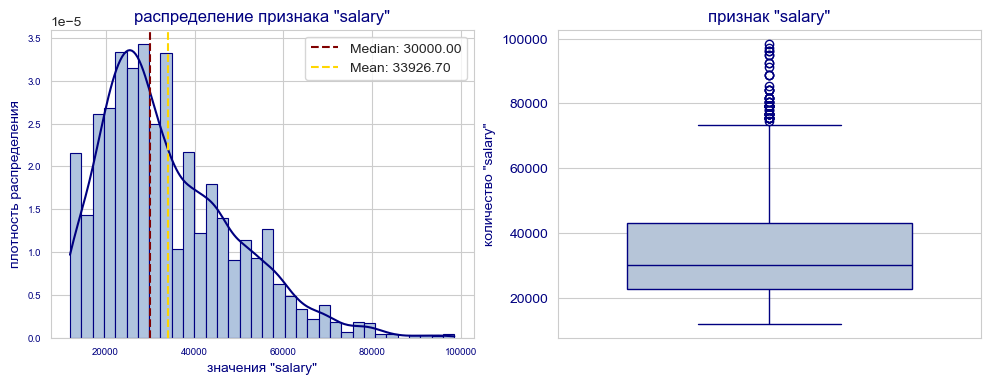

In [58]:
for column in case_1_continuous_cols:
    continuous_data_plot(train_satisfaction, column)

In [59]:
# посмотрим на данные по сотрудникам, чьи зарплаты превышают 
print('Зарплату свыше 75 тыс получает {} сотрудников, занимающих должности: {}, - и с загрузкой {}'.format(train_satisfaction.query('salary >= 75000')['id'].count(), train_satisfaction.query('salary >= 75000')['level'].unique(), train_satisfaction.query('salary >= 75000')['workload'].unique()))
train_satisfaction.query('salary >= 75000').sort_values(by='salary', ascending=False).head(5)

Зарплату свыше 75 тыс получает 59 сотрудников, занимающих должности: ['sinior'], - и с загрузкой ['high']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2845,839346,technology,sinior,high,5,no,no,5,98400,0.67
3839,868744,technology,sinior,high,5,yes,no,4,97200,0.84
3024,494924,technology,sinior,high,6,no,no,4,96000,0.89
2901,930908,technology,sinior,high,10,no,no,4,96000,0.92
2750,493986,technology,sinior,high,9,yes,no,4,94800,0.99


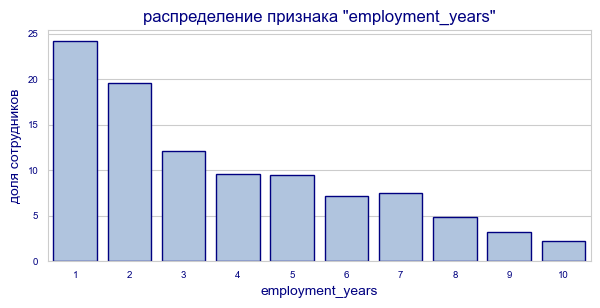

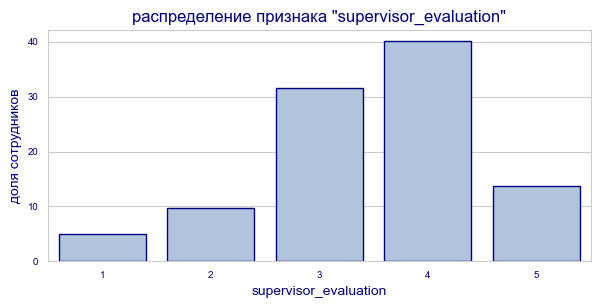

In [60]:
for column in case_1_descrete_cols:
    plt.figure(figsize=(7,3))
    descrete_data_plot(train_satisfaction, column)

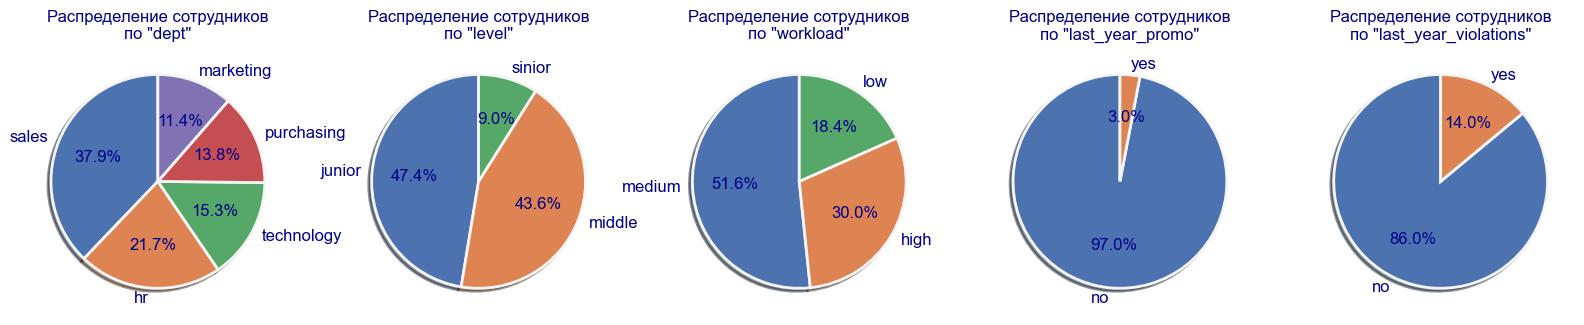

In [61]:
i = 1
plt.figure(figsize=(20,10))
for col in case_1_cat_cols:
    cat_data_plot(train_satisfaction, col, len(case_1_cat_cols), i)
    i +=1

#### Анализ данных тестовой выборки

In [63]:
display(test_satisfaction.drop('id', axis=1).describe(percentiles=[.125, .5, .875]))
test_satisfaction.describe(include='object')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,"2,000.00","2,000.00","2,000.00","2,000.00"
mean,3.67,3.53,"34,066.80",0.55
std,2.54,1.00,"15,398.44",0.22
min,1.00,1.00,"12,000.00",0.03
12.5%,1.00,2.00,"19,200.00",0.26
50%,3.00,4.00,"30,000.00",0.58
87.5%,7.00,5.00,"54,000.00",0.79
max,10.00,5.00,"96,000.00",1.00


,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


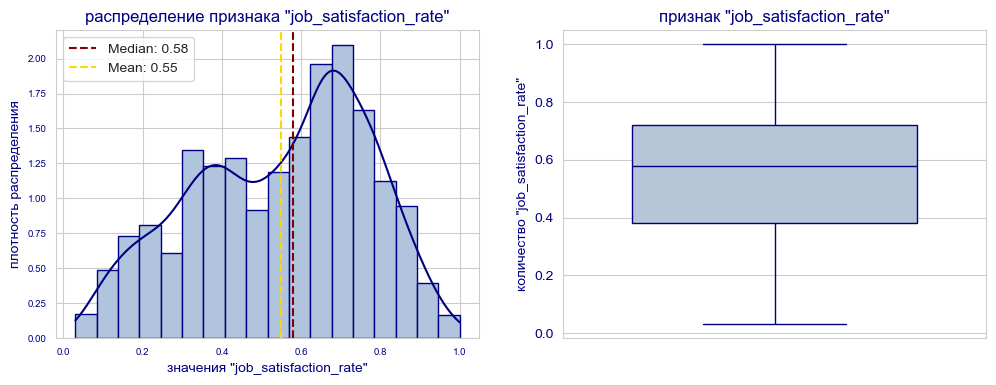

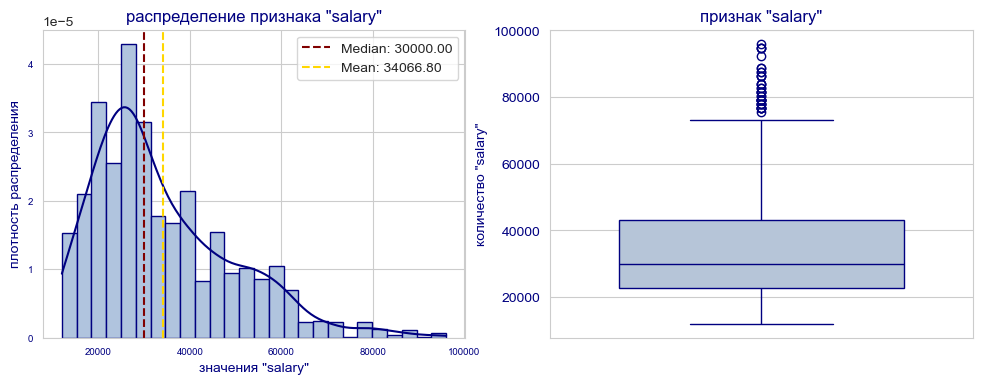

In [64]:
for column in case_1_continuous_cols:
    continuous_data_plot(test_satisfaction, column)

In [65]:
# посмотрим на данные по сотрудникам, чьи зарплаты превышают 
print('Зарплату свыше 75 тыс получает {} сотрудников, занимающих должности: {}, - и с загрузкой {}'.format(test_satisfaction.query('salary >= 75000')['id'].count(), test_satisfaction.query('salary >= 75000')['level'].unique(), test_satisfaction.query('salary >= 75000')['workload'].unique()))
test_satisfaction.query('salary >= 75000').sort_values(by='salary', ascending=False).head(5)

Зарплату свыше 75 тыс получает 39 сотрудников, занимающих должности: ['sinior'], - и с загрузкой ['high']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
793,510806,technology,sinior,high,5,no,no,4,96000,0.65
1376,796517,technology,sinior,high,9,no,yes,4,94800,0.65
438,270400,technology,sinior,high,2,no,no,4,94800,0.70
765,205752,technology,sinior,high,9,no,no,5,94800,0.80
1933,585043,technology,sinior,high,4,no,yes,2,92400,0.21


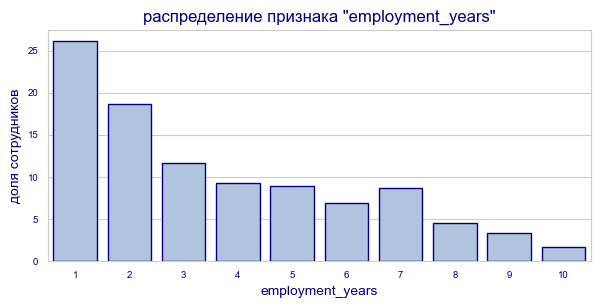

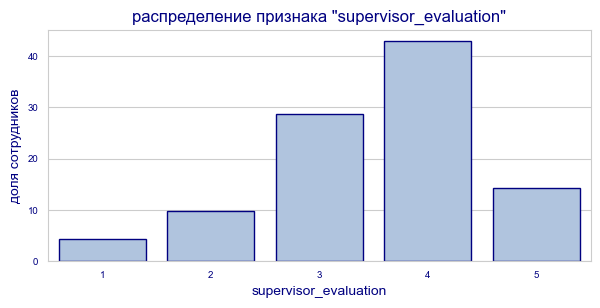

In [66]:
for column in case_1_descrete_cols:
    plt.figure(figsize=(7,3))
    descrete_data_plot(test_satisfaction, column)

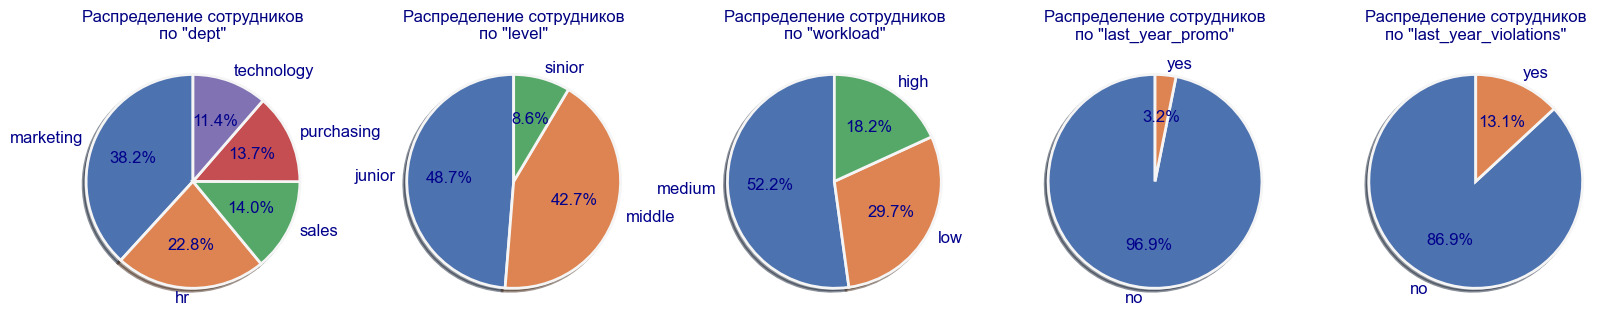

In [67]:
i = 1
plt.figure(figsize=(20,10))
for col in case_1_cat_cols:
    cat_data_plot(test_satisfaction, col, len(case_1_cat_cols), i)
    i +=1

#### Анализ объединенных данных тренировочной и тестовой выборок

In [69]:
display(case_1.drop('id', axis=1).describe(percentiles=[.125, .5, .875]))
case_1.describe(include='object')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,"6,000.00","6,000.00","6,000.00","6,000.00"
mean,3.70,3.49,"33,973.40",0.54
std,2.54,1.01,"15,067.30",0.22
min,1.00,1.00,"12,000.00",0.03
12.5%,1.00,2.00,"19,200.00",0.24
50%,3.00,4.00,"30,000.00",0.57
87.5%,7.00,5.00,"52,800.00",0.80
max,10.00,5.00,"98,400.00",1.00


,dept,level,workload,last_year_promo,last_year_violations
count,5992,5995,6000,6000,6000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,2275,2868,3109,5817,5179


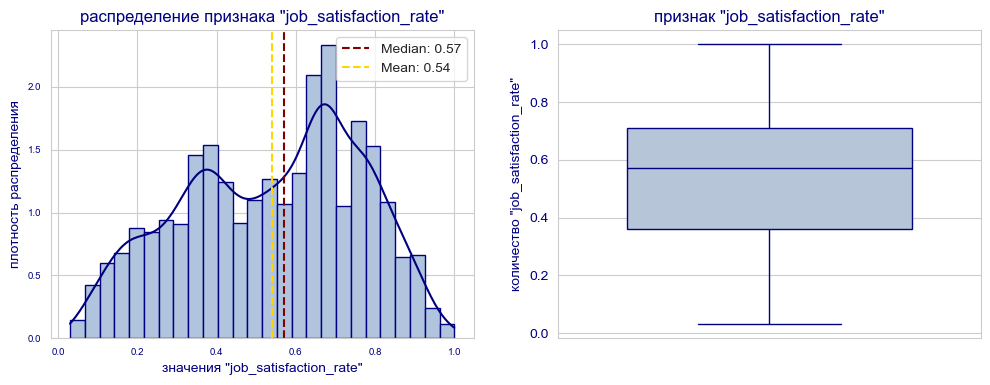

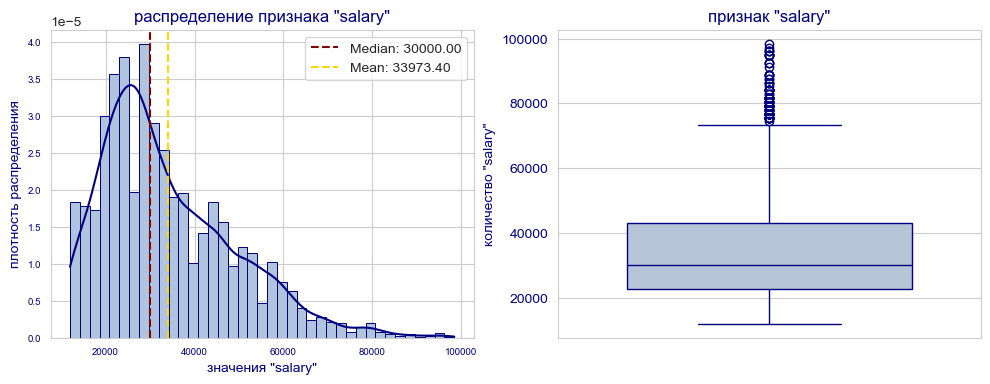

In [70]:
for column in case_1_continuous_cols:
    continuous_data_plot(case_1, column)

In [71]:
# посмотрим на данные по сотрудникам, чьи зарплаты превышают 
# посмотрим на данные по сотрудникам, чьи зарплаты превышают 
print('Зарплату свыше 75 тыс получает {} сотрудников, занимающих должности: {}, - и с загрузкой {}'.format(case_1.query('salary >= 75000')['id'].count(), case_1.query('salary >= 75000')['level'].unique(), case_1.query('salary >= 75000')['workload'].unique()))
case_1.query('salary >= 75000').sort_values(by='salary', ascending=False).head(5)

Зарплату свыше 75 тыс получает 98 сотрудников, занимающих должности: ['sinior'], - и с загрузкой ['high']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2845,839346,technology,sinior,high,5,no,no,5,98400,0.67
3839,868744,technology,sinior,high,5,yes,no,4,97200,0.84
793,510806,technology,sinior,high,5,no,no,4,96000,0.65
2901,930908,technology,sinior,high,10,no,no,4,96000,0.92
3024,494924,technology,sinior,high,6,no,no,4,96000,0.89


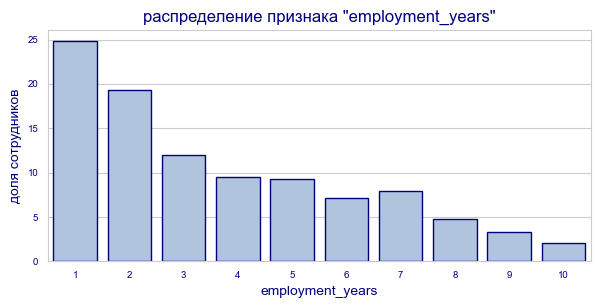

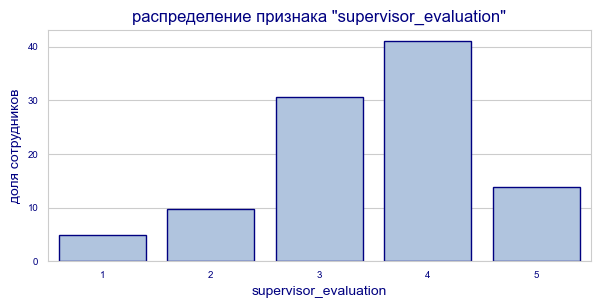

In [72]:
for column in case_1_descrete_cols:
    plt.figure(figsize=(7,3))
    descrete_data_plot(case_1, column)

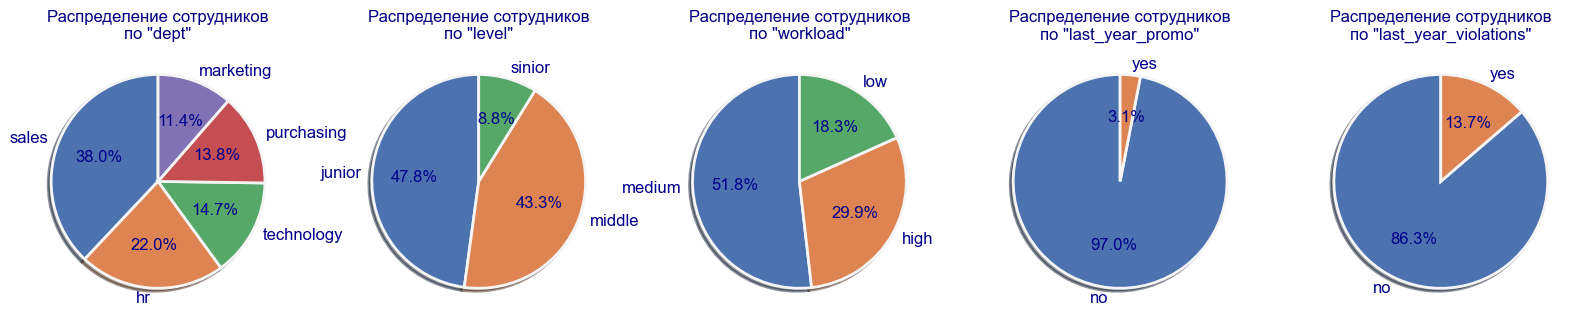

In [73]:
i = 1
plt.figure(figsize=(20,10))
for col in case_1_cat_cols:
    cat_data_plot(case_1, col, len(case_1_cat_cols), i)
    i +=1

#### Резюме анализа данных для первой задачи

<font color='Darkblue'><b><i>Анализ данных в разрезе выборок показал отсутствие значительного отличия распределения нескольких или всех признаков  обучающей выборки от распределения одноименных признаков в тестовой, т.е. отсутствие так называемого дата-дрифта, котороый может привести к деградации модели<br>

<font color='Darkblue'><b><i>1. Количественные показатели, характеризующие сотрудников</b></i>:<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b> a) непрерывные количественные признаки</b><br>&nbsp;&nbsp;&nbsp;- <b>`job_satisfaction_rate`</b>(уровень удовлетворенности сотрудников работой в компании) - целевой признак - распределение бимодальное, т.к. наблюдается 2 пика (оценка около 0.35-0.4 и оценка около 0.65-0.7): 75% оценивают свою удовлетворённость в довольно широком диапазоне от 0.24 до 0.8, средняя и медианные оценки довольно близки по значению - 0.54 и 0.57 соответственно<br>&nbsp;&nbsp;&nbsp;- <b>`salary`</b> (зарплата) - ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды): 75% сотрудников получают зарплату в диапазоне от 19,200 до 52,800, среднее и медианное значения зарплаты довольно близки по уровню: 33,973.4 и 30,000 соответственно. Анализ выбросов значений зарплаты, показал, что в датасете присутсвуют данные о 98 высокооплачиваемых сотрудниках (зарплата более 75 тыс), занимающих позиции `senior`<br>&nbsp;&nbsp;&nbsp;<b> b) дискретные количественные признаки</b><br>&nbsp;&nbsp;&nbsp;- <b>`employment_years`</b> (длительность работы в компании): наибольшая доля сотрудников проработала в компании 1-2 года, на графике четко видна тенеднция снижения количества сотрудников с ростом стажа в компании<br>&nbsp;&nbsp;&nbsp;- <b>`supervisor_evaluation`</b> (оценка качества работы сотрудника руководителем): самая частая оценка сотрудников (чуть более 40%) - 4, с самой низкой оценкой - 1, работает не более 5% сотрудников, с максимальной (5) - около 15%

<font color='Darkblue'><b><i>2. Категорийные показатели, характеризующие сотрудников</b></i><br>&nbsp;&nbsp;&nbsp;- `dept`(отдел, в котором работает сотрудник) - всего представлено 5 отделов: 'sales', 'hr', 'technology', 'purchasing' и 'marketing', в данных больше всего сотрудников отдела 'sales' - 38%<br>&nbsp;&nbsp;&nbsp;- `level`(уровень занимаемой должности) - три категории: 'junior', 'middle' и 'snior', преобладает уровень 'junior' - 47.8% <br>&nbsp;&nbsp;&nbsp;- `workload` (уровень загрузки) - три категории: 'low', 'medium' и 'high', преобладает уровень 'medium' - 51.8% <br>&nbsp;&nbsp;&nbsp;- `last_year_promo` (наличие продвижения за последний год) - две категории: 'yes' и 'no', преобладают сотрудники без продвижения - 97.0%<br>&nbsp;&nbsp;&nbsp;- `last_year_violations`(нарушения трудового договора за последний год) - две категории: 'yes' и 'no', преобладают сотрудники без нарушений - 86.3%

<font color='Darkblue'><b><i>3. Для дальнейшей подготовки данных необходимо отметить:</b></i><br>&nbsp;&nbsp;&nbsp; - количественные признаки `salary`, `supervisor_evaluation` и `employment_years` целесообразно масштабировать<br>&nbsp;&nbsp;&nbsp; - категорийные признаки `level` и `workload` целесообразно кодировать с помощью OrdinalEncoderbr <br>&nbsp;&nbsp;&nbsp; - категорийные признаки `dept`, `last_year_promo` и `last_year_violations` целесообразно кодировать с помощью OneHotEncoder<br>&nbsp;&nbsp;&nbsp; - целевой признак `job_satisfaction_rate` ввиду того, что он представлен непрерывными количественными данными, кодированию не подлежит

### Анализ данных для второй задачи

In [80]:
# Определеим перечень колонок, относящихся к количественным (непрерывным и дискретным) и категориальным данным
# непрерывные количесвтенные данные - зарплата и уровень удовлетворенности работой (целевой признак)
case_2_continuous_cols = ['salary']
# дискреные количесвтенные данные - количество отработанных в компании лет и оценка руководителя
case_2_descrete_cols = ['employment_years', 'supervisor_evaluation']
# категориальные данные
case_2_cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [81]:
#Сформируем тестовую выборку, объединив входящие признаки с целевым
test_quit = test_features.merge(test_target_quit, on='id', how='left')
# Сформируем объединенные данные второй задачи
case_2 = pd.concat([train_quit, test_quit], axis=0)

In [82]:
# Посмотрим на распределение целевого признака в выборках, для чего напишем функцию
def quit_struct(df, name, ncols, naxes):
    plt.subplot(1, ncols, naxes)
    plt.title(f'Соотношение уволившихся и \nработающих сотрудников\n в "{name}"', color='navy', fontsize=10)
    plt.pie(x=df['id'],
            startangle=90, explode=explode,
            labeldistance=1.1, 
            wedgeprops={'linewidth': 2, 'edgecolor':'whitesmoke'}, shadow=True, \
            textprops={'fontsize': 10, 'color': 'darkblue'},
            autopct='%1.1f%%',
            labels=[x for x in list(df['quit'].unique())], 
            colors={'lightsteelblue', 'steelblue'})

проверка соотношения занчений целевого признака по выборкам


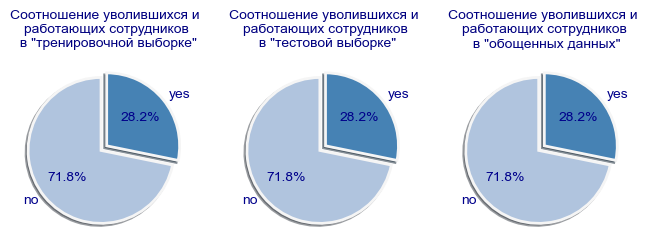

In [83]:
trait_quit_subset = train_quit[['id', 'quit']].groupby('quit', as_index=False).agg({'id':'nunique'})
test_quit_subset = test_quit[['id', 'quit']].groupby('quit', as_index=False).agg({'id':'nunique'})
total_quit_subset = case_2.groupby('quit', as_index=False).agg({'id':'nunique'})
df_list = [trait_quit_subset, test_quit_subset, total_quit_subset]
sub_name = ['тренировочной выборке', 'тестовой выборке', 'обощенных данных']
explode = [0.1,0]
i = 1
plt.figure(figsize=(8,3))
try:
    for df_name in df_list:
        for sub in sub_name:
            quit_struct(df_name, sub, len(df_list), i)
            i +=1
except:
    print('проверка соотношения занчений целевого признака по выборкам')

<font color='Darkblue'><i> Целевой признак несбалансирован, но дисбаланс во всех выборках имеет одинаковую пропорцию: 71.8% сотрудников представленных в данных не уволены

#### Анализ данных тренировочной выборки

In [86]:
display(train_quit.drop('id', axis=1).describe(percentiles=[.125, .5, .875]))
case_2.describe(include='object')

,employment_years,supervisor_evaluation,salary
count,"4,000.00","4,000.00","4,000.00"
mean,3.70,3.47,"33,805.80"
std,2.54,1.00,"15,152.42"
min,1.00,1.00,"12,000.00"
12.5%,1.00,2.00,"19,200.00"
50%,3.00,4.00,"30,000.00"
87.5%,7.00,5.00,"52,800.00"
max,10.00,5.00,"96,000.00"


,dept,level,workload,last_year_promo,last_year_violations,quit
count,5998,5999,6000,6000,6000,6000
unique,6,3,4,2,2,2
top,sales,junior,medium,no,no,no
freq,2201,2923,3161,5824,5193,4308


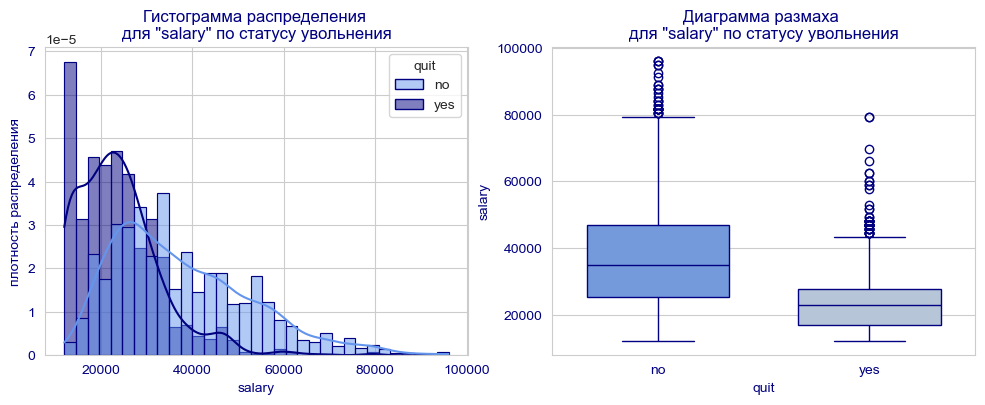

In [87]:
for column in case_2_continuous_cols:
    continuous_data_plot_2(train_quit, column)

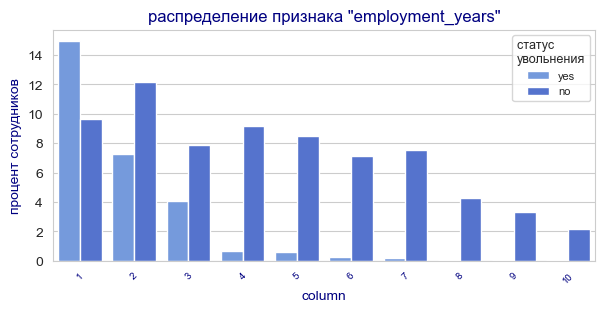

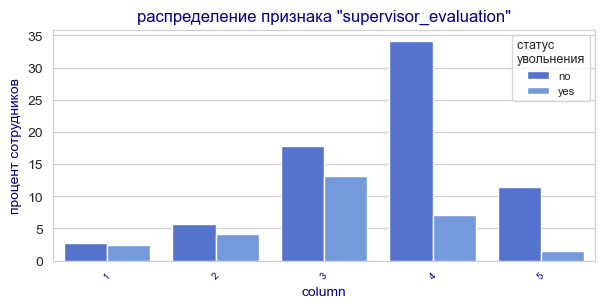

In [88]:
for column in case_2_descrete_cols:
    plt.figure(figsize=(7,3))
    descrete_data_plot_2(train_quit, column)

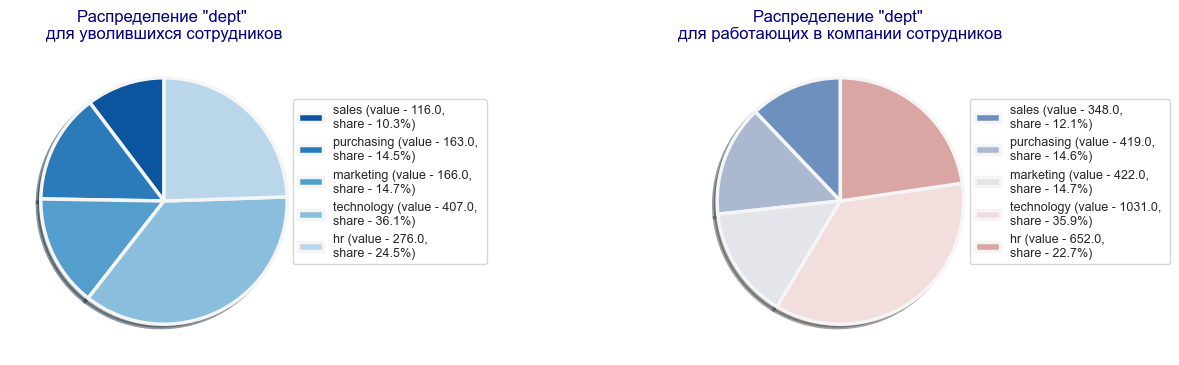

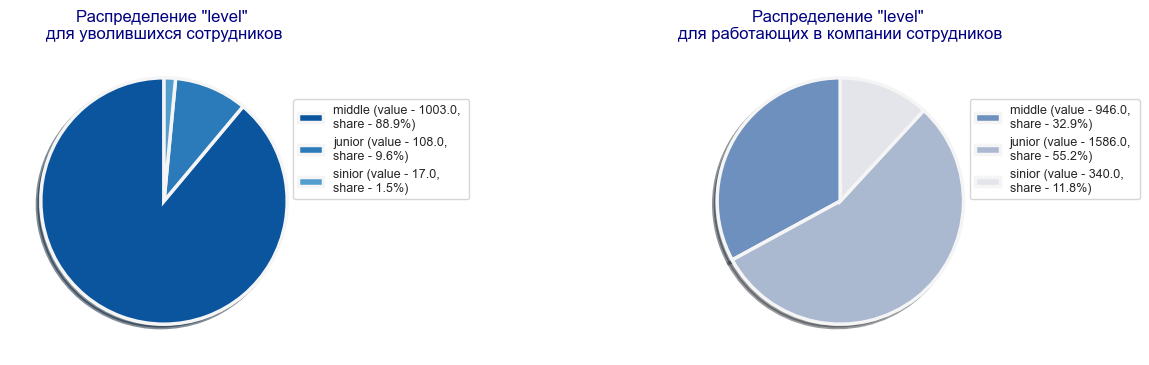

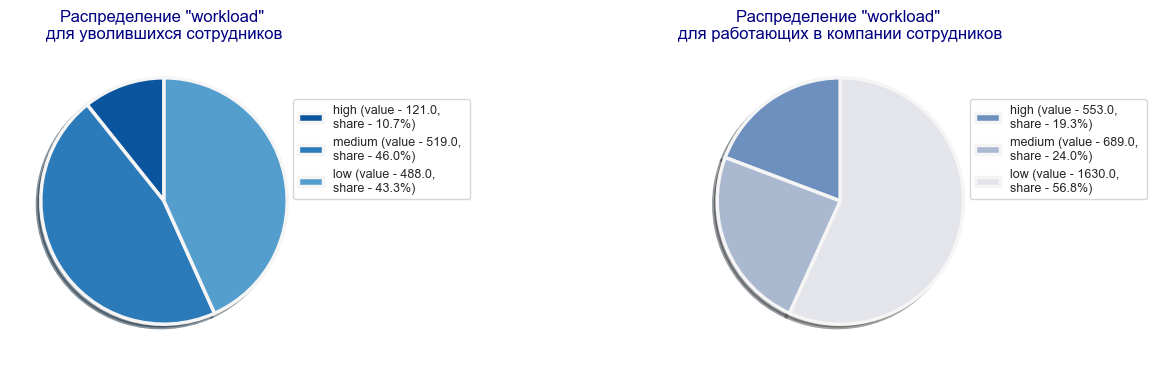

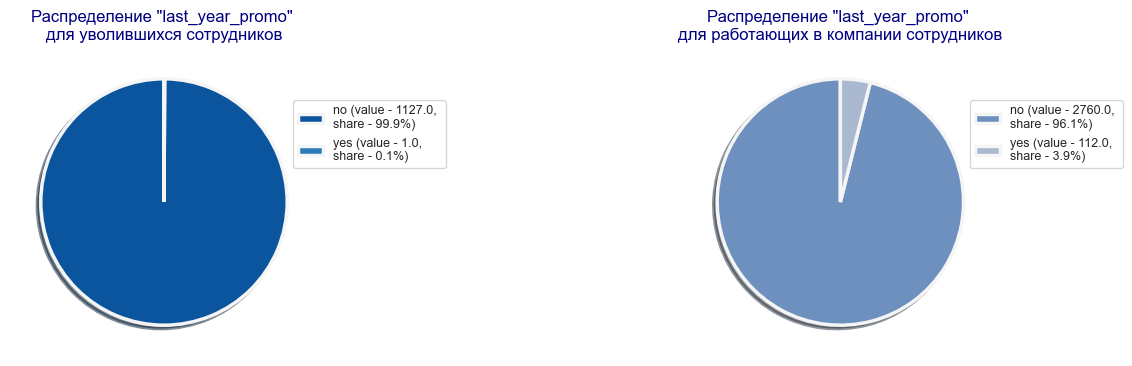

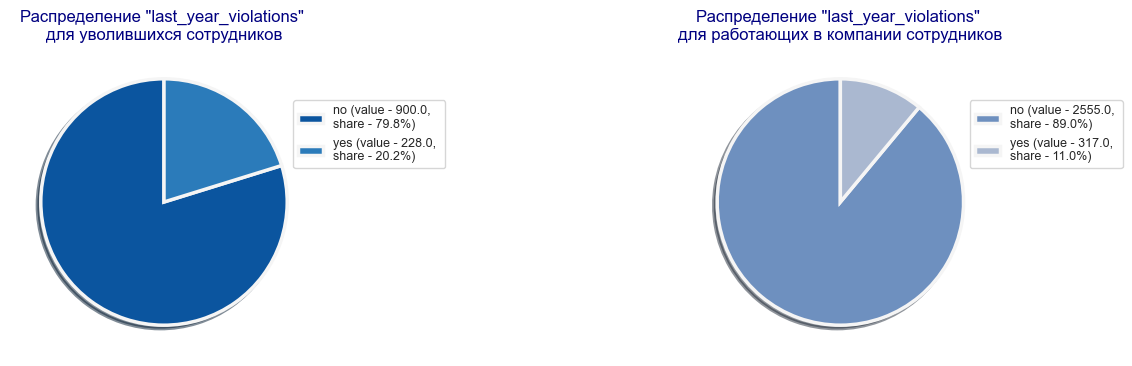

In [89]:
for col in case_2_cat_cols:
    cat_data_plot_2(train_quit, col)

#### Анализ данных тестовой выборки

In [91]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB


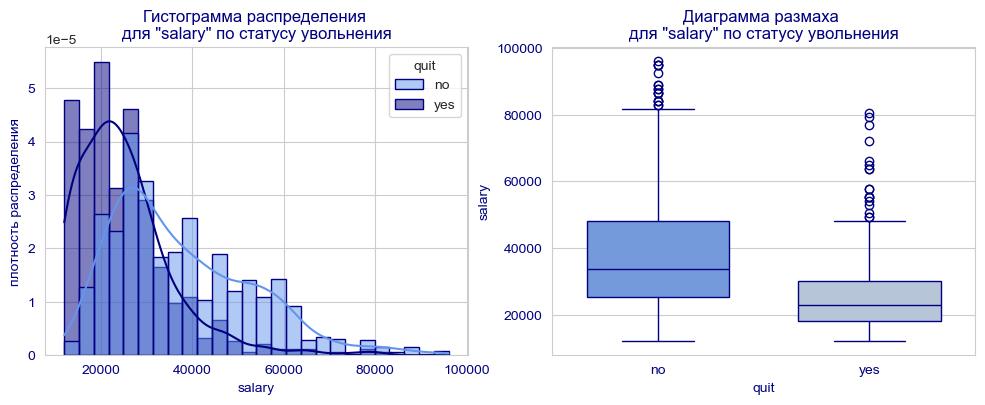

In [92]:
for column in case_2_continuous_cols:
    continuous_data_plot_2(test_quit, column)

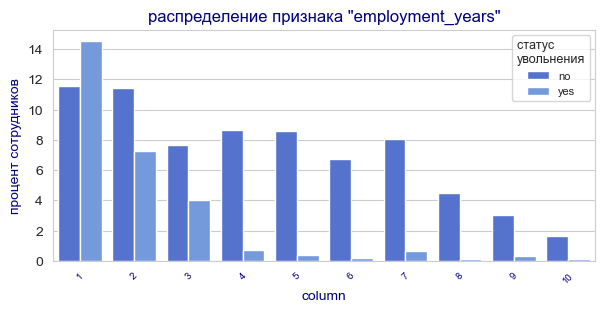

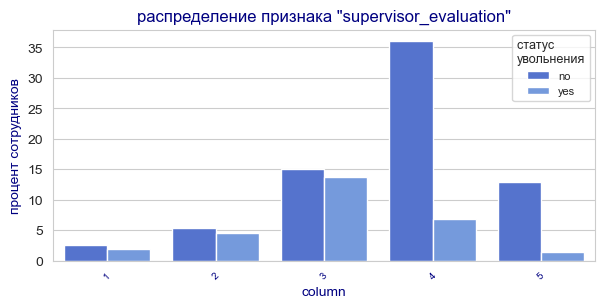

In [93]:
for column in case_2_descrete_cols:
    plt.figure(figsize=(7,3))
    descrete_data_plot_2(test_quit, column)

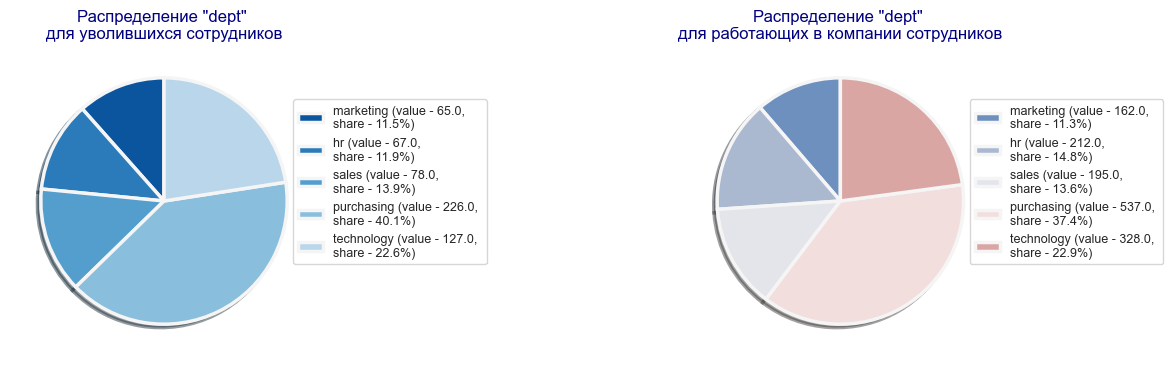

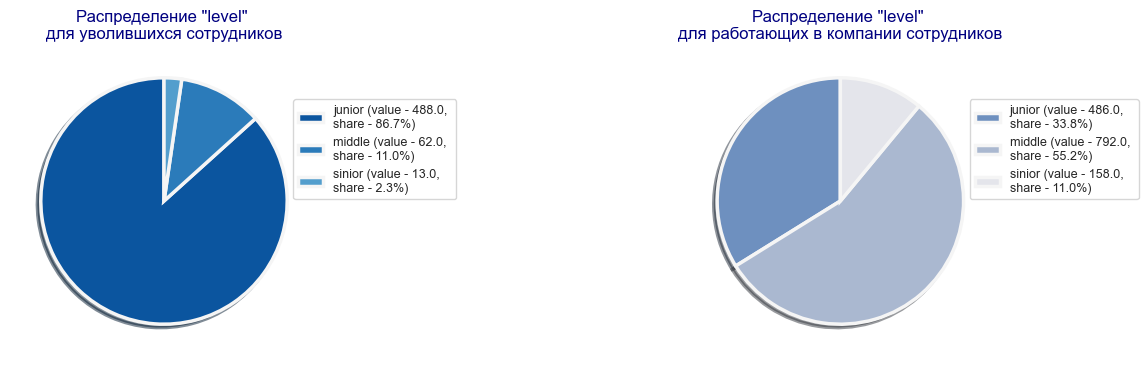

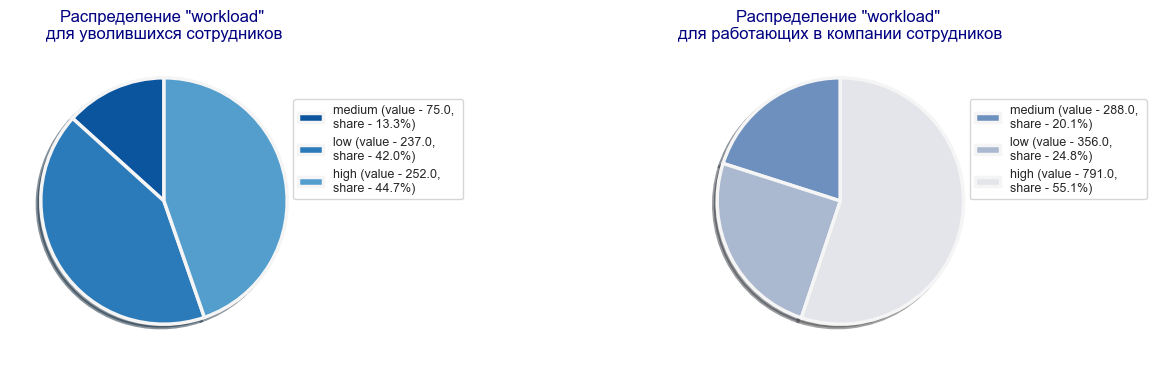

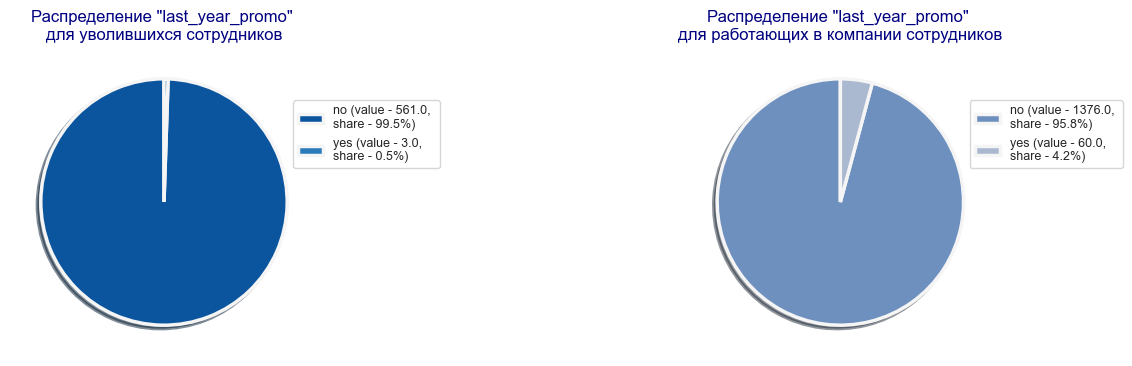

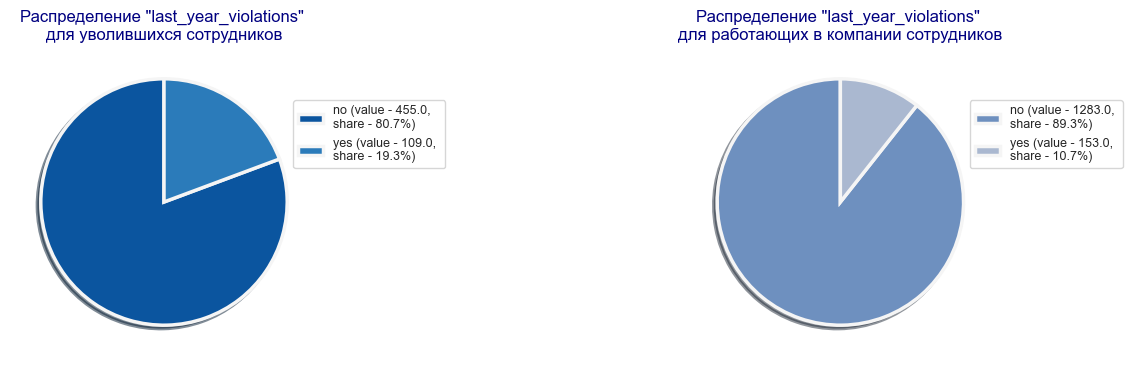

In [94]:
for col in case_2_cat_cols:
    cat_data_plot_2(test_quit, col)

#### Анализ объединенных даных тренировочной и тестовой выборки

In [96]:
display(case_2.drop('id', axis=1).describe(percentiles=[.125, .5, .875]))
case_2.describe(include='object')

,employment_years,supervisor_evaluation,salary
count,"6,000.00","6,000.00","6,000.00"
mean,3.69,3.49,"33,892.80"
std,2.54,1.00,"15,234.08"
min,1.00,1.00,"12,000.00"
12.5%,1.00,2.00,"19,200.00"
50%,3.00,4.00,"30,000.00"
87.5%,7.00,5.00,"52,800.00"
max,10.00,5.00,"96,000.00"


,dept,level,workload,last_year_promo,last_year_violations,quit
count,5998,5999,6000,6000,6000,6000
unique,6,3,4,2,2,2
top,sales,junior,medium,no,no,no
freq,2201,2923,3161,5824,5193,4308


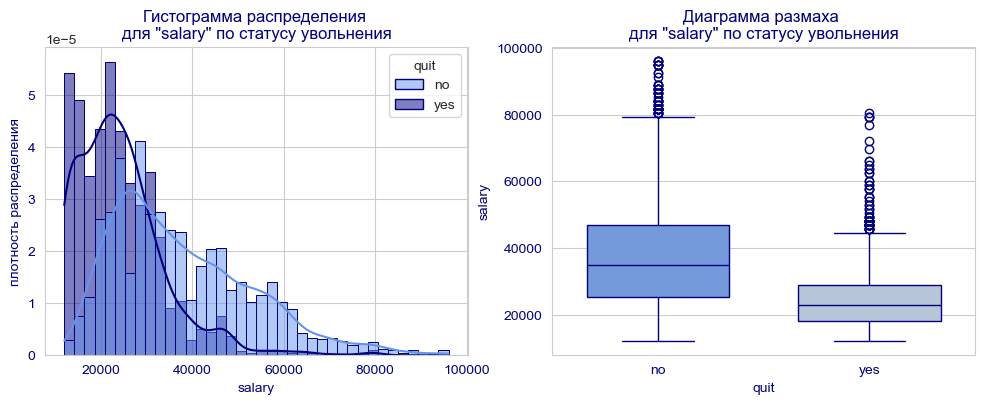

In [97]:
for column in case_2_continuous_cols:
    continuous_data_plot_2(case_2, column)

In [98]:
# посмотрим на данные по сотрудникам, чьи зарплаты превышают 
print('Зарплату свыше 75 тыс получает {} сотрудников, занимающих должности: {}'.format(case_2.query('salary >= 75000')['id'].count(), case_2.query('salary >= 75000')['level'].unique()))
print('Из них уволилось {} сотрудников'.format(case_2.query('salary >= 75000 and quit =="yes"')['id'].count(), case_2.query('salary >= 75000 and quit =="yes"')['level'].unique()))
print('Зарплату менее 20 тыс получает {} сотрудников, занимающих должности: {}'.format(case_2.query('salary < 20000')['id'].count(), case_2.query('salary < 20000')['level'].unique()))
print('Из них уволилось {} сотрудников'.format(case_2.query('salary < 20000 and quit =="yes"')['id'].count(), case_2.query('salary < 20000 and quit =="yes"')['level'].unique()))

Зарплату свыше 75 тыс получает 111 сотрудников, занимающих должности: ['sinior']
Из них уволилось 5 сотрудников
Зарплату менее 20 тыс получает 988 сотрудников, занимающих должности: ['junior' 'middle' nan]
Из них уволилось 605 сотрудников


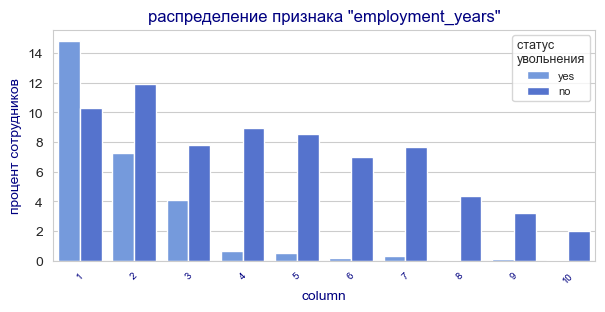

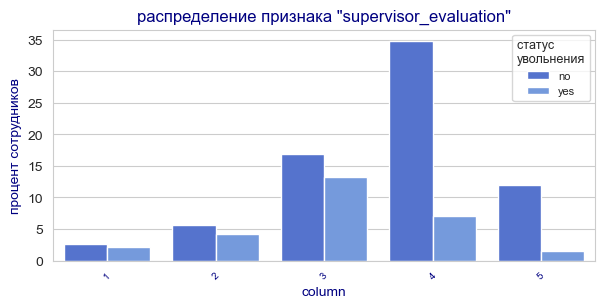

In [99]:
for column in case_2_descrete_cols:
    plt.figure(figsize=(7,3))
    descrete_data_plot_2(case_2, column)

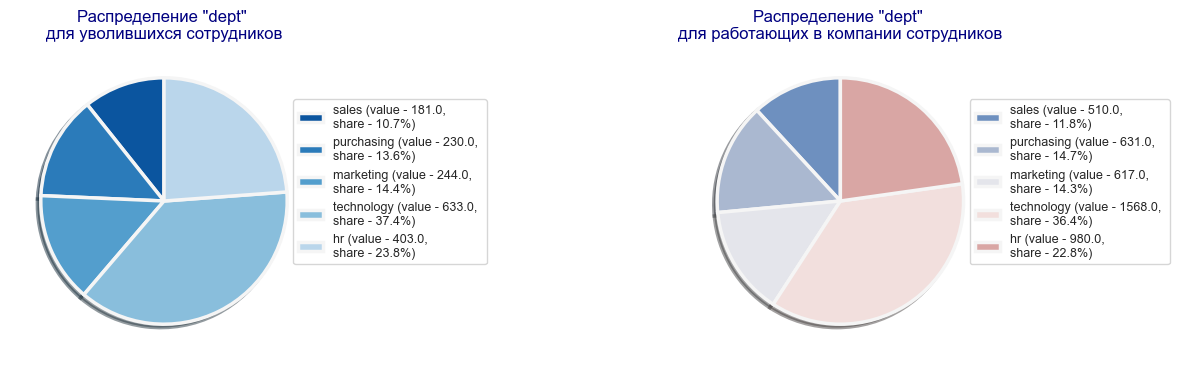

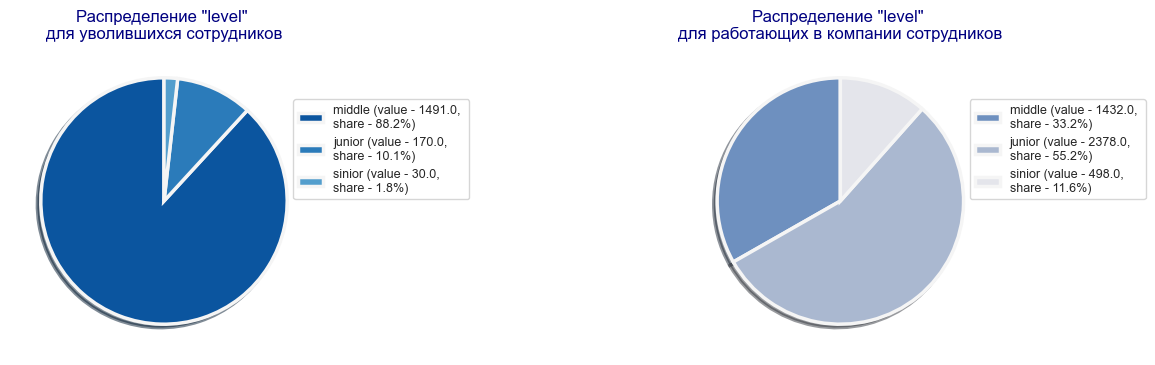

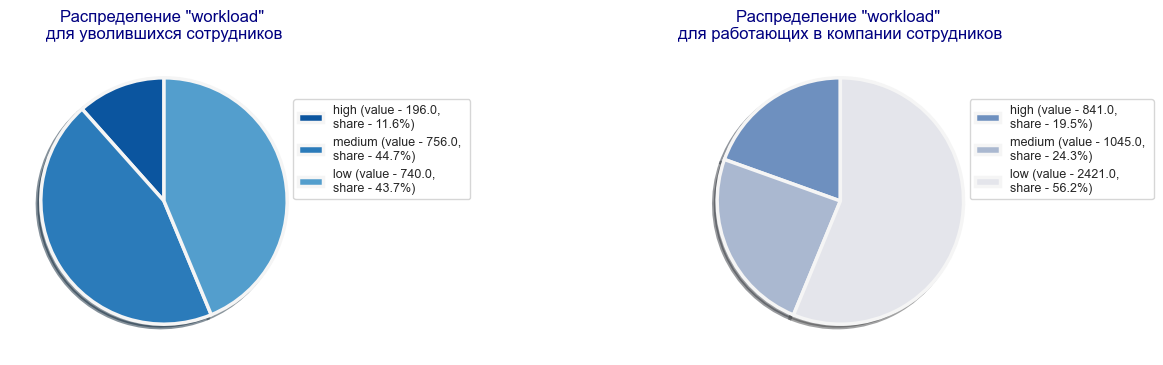

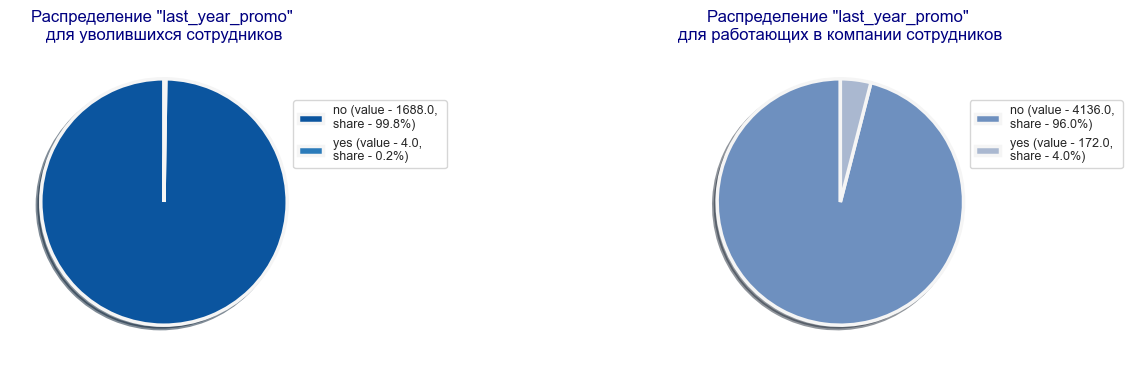

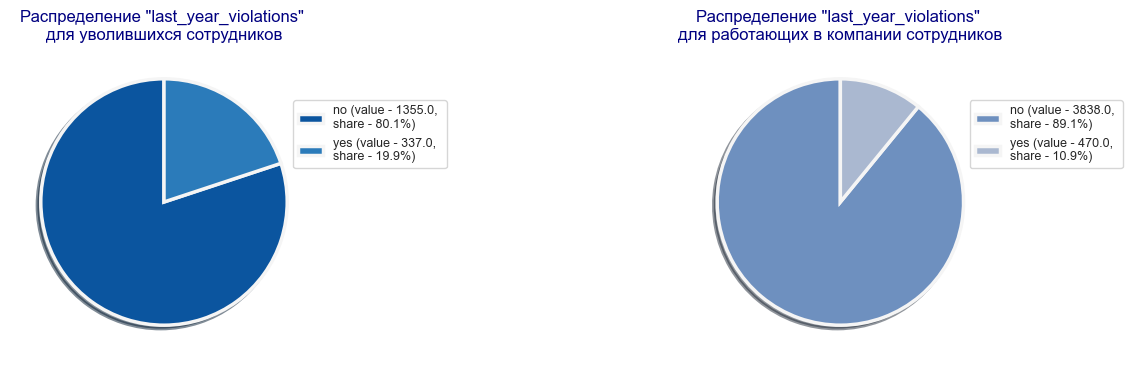

In [100]:
for col in case_2_cat_cols:
    cat_data_plot_2(case_2, col)

#### Резюме анализа данных для второй задачи

<font color='Darkblue'><b><i> Анализ данных в разрезе выборок показал наличие различий в структуре данных о представленности департаментов, занимаемых доложностях и загруженности персонала. </b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`dept`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном пердставители отделов `technolgy`(36.1%), `hr` (24.5%) и `purchase` (14.5%), <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном пердставители отделов `purchase` (40.1%), `technolgy`(22.6%) и `sales` (13.9%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; такой же дисбаланс и среди работающих в тренировочной и тестовой выборках<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`level`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном пердставители позиций `middle`(88.9%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном пердставители позиций `junior` (55.2%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; чуть менее выраженный дисбаланс и среди работающих в тренировочной и тестовой выборках: работает в тренировочной выборке больше  специалистов уровня `junior`(55.2%), в тестовой превалируют сотрудники уровня `middle` (55.2%)<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`workload`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном сотрудники с загрузкой `medium`(46.0%) и `low`(43.3%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном сотрудники с загрузкой `high` (44.7%) и `low`(42.0%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; такой же дисбаланс и среди работающих в тренировочной и тестовой выборках: работает в тренировочной выборке больше сотрудников с загрузкой `low`(56.8%), в тестовой превалируют сотрудники c загрузкой `high` (55.1%)

<font color='Darkblue'><b><i>Такой дисбаланс входных признаков может негативно отразиться на модели, особенно если вышеуказанные признаки окажутся значимыми с точки зрения наилучшей модели обученной на тренировочных данных. Такой дисбаланс можно частично снять на кросс-валидации. Однако если подобная тенденци изменения структуры входных признаков созранится, необходимо обратить внимание Заказчика, на необходимость изменения тренировочного и тестового наборов данных и перенастройки модели.

<font color='Darkblue'><b><i> Анализ объединенных данных показал следующие результаты</b></i><br>
<font color='Darkblue'><b><i>1. Количественные показатели, характеризующие сотрудников</b></i>:<br>&nbsp;&nbsp;&nbsp;<b> a) непрерывный количественный признак</b><br>&nbsp;&nbsp;&nbsp;- <b>`salary`</b> (зарплата) - ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды): 75% сотрудников получают зарплату в диапазоне от 19,200 до 52,800, среднее и медианное значения зарплаты довольно близки по уровню: 33,892.8 и 30,000 соответственно.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Анализ выбросов значений зарплаты, показал, что в датасете присутсвуют данные о 111 высокооплачиваемых сотрудниках (зарплата более 75 тыс), занимающих позиции `senior`, из которых уволилось только 5 сотрудников. Тогда как сотрудников с низкой зарплатой (менее 20 тыс) в выборке 988, из которых уволилось 605 сотрудников <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <i>Анализ в разрезе признака `quit` (уволен/работает) показал, что зарплата уволившихся сотрудников в основном ниже (диапазон 15-25 тыс), чем работающих (диапазон 25-50 тыс)</i><br>&nbsp;&nbsp;&nbsp;<b> b) дискретные количественные признаки</b><br>&nbsp;&nbsp;&nbsp;- <b>`employment_years`</b> (длительность работы в компании) в разрезе статуса увольнения показывает, что наибольшая часть сотрудников, проработавших в компании 1 год - это уволившиеся сотрудники, их доля падает с ростом стажа работы в компании, со стажем более 3х лет среди уволившихся единицы<br>&nbsp;&nbsp;&nbsp;- <b>`supervisior_evaluation`</b> (оценка качества работы сотрудника руководителем): самая частая оценка уволившихся сотрудников - 3

<font color='Darkblue'><b><i>2. Категорийные показатели, характеризующие сотрудников</b></i><br>&nbsp;&nbsp;&nbsp;- `dept`(отдел, в котором работает сотрудник) - увольняются и продолжают работать по отделам примерно в одинаковом соотношении с небольшим перевесом уволившихся из отделов `technolgy` и `hr`<br>&nbsp;&nbsp;&nbsp;- `level`(уровень занимаемой должности) - 88% уволившихся занимали должность `middle`, 55% работающих в компании работают в позиции `junior` <br>&nbsp;&nbsp;&nbsp;- `workload` (уровень загрузки) - увольняются почти в равной степени как с загрузкой `medium`, так и с загрузкой `low`, тогда как работают в основном сотрудники с загрузкой `low` <br>&nbsp;&nbsp;&nbsp;- `last_year_promo` (наличие продвижения за последний год) - в обеих подгруппах превалирует доля без продвижения, но среди уволившихся их 99.8%<br>&nbsp;&nbsp;&nbsp;- `last_year_violations`(нарушения трудового договора за последний год) - среди уволившихся почти в два раза больше сотрудников, нарушивших трудовой договор, чем среди тех, кто продолжает работать в компании.

<font color='Darkblue'>3. В дополнение к раннее отмеченным особенностям <b>подготовки данных к моделированию</b> необходимо отметить:</b></i><br>&nbsp;&nbsp;&nbsp; - целевой признак `quit` целесообразно кодировать с помощью LabelEncoder<br>&nbsp;&nbsp;&nbsp; - целевой признак несбалансирован, поэтому в рамках определения метрики лучшей модели на крос-валидации необходимо использовать метод Stratified K-Fold, который позволит сохранить пропорции классов в каждом 'фолде'

### Анализ сводных данных тестовой выборки

In [108]:
# объединим все данные тестовой выборки в один датасет
test_data_satisfaction = test_features.merge(test_target_satisfaction, on='id', how='left')
test_data = test_data_satisfaction.merge(test_target_quit, on='id', how='left')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB


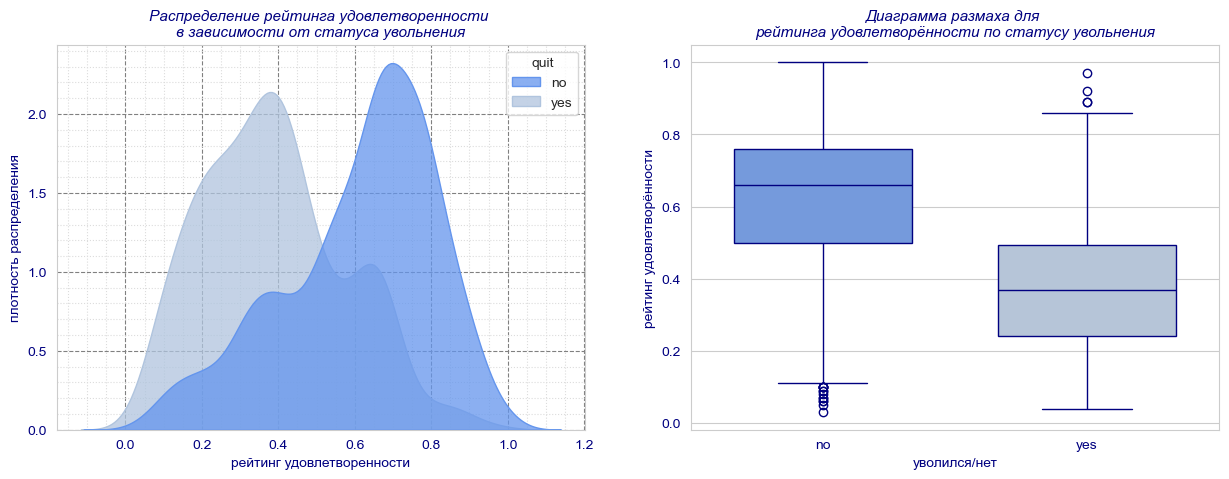

In [109]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(test_data, x = 'job_satisfaction_rate', hue='quit', 
                 fill=True, common_norm=False, palette={'lightsteelblue', 'cornflowerblue'},
                   alpha=.75, linewidth=1)
plt.title('Распределение рейтинга удовлетворенности \nв зависимости от статуса увольнения', \
          color='navy', fontstyle='italic', fontsize=11)
plt.xlabel('рейтинг удовлетворенности', color='navy', fontsize=10)
plt.ylabel('плотность распределения' , \
           color='navy', fontsize=10)
plt.xticks(color='navy', fontsize=10)
plt.yticks(color='navy', fontsize=10)
plt.grid(color='grey', linestyle='--')
plt.minorticks_on()
plt.grid(which='minor', color='gainsboro', ls=':')

plt.subplot(1, 2, 2)
sns.boxplot(data=test_data, x='quit', y='job_satisfaction_rate', hue='quit', 
                palette ={'yes': 'lightsteelblue', 'no': 'cornflowerblue'}, fill=True, gap=.1, width=.75, \
                linecolor='navy')
plt.title('Диаграмма размаха для \nрейтинга удовлетворённости по статусу увольнения', 
          color='navy', fontstyle='italic', fontsize=11)
plt.ylabel('рейтинг удовлетворённости', fontsize=10, color='navy')
plt.xlabel('уволился/нет', fontsize=10, color='navy')
plt.yticks(fontsize=10, color='navy')
plt.xticks(fontsize=10, color='navy')
plt.show()

In [110]:
print('Средний рейтинг удовлетворённости уволившихся сотрудников - ', round(test_data.query('quit == "yes"')['job_satisfaction_rate'].mean(), 2))
print('Средний рейтинг удовлетворённости работающих сотрудников - ', round(test_data.query('quit == "no"')['job_satisfaction_rate'].mean(), 2))

Средний рейтинг удовлетворённости уволившихся сотрудников -  0.39
Средний рейтинг удовлетворённости работающих сотрудников -  0.61


<font color='Darkblue'><i>Из представленных выше графиков явно следует, что <br>- чем выше рейтинг удовлетворенности сотрудника работой в компании, тем выше плотность распределения для работающих сотрудников<br>- чем ниже рейтинг удовлетворенности, тем выше плотность распределения для уволившихся<br>- средний рейтинг уволившихся - 0.39, средний рейтинг работающих - 0.61

### Корреляционный анализ данных

In [113]:
# считаем корреляцию для признаков первой задачи
phik_overview_case_1 = phik_matrix(case_1.drop('id', axis=1), interval_cols=case_1_continuous_cols) 

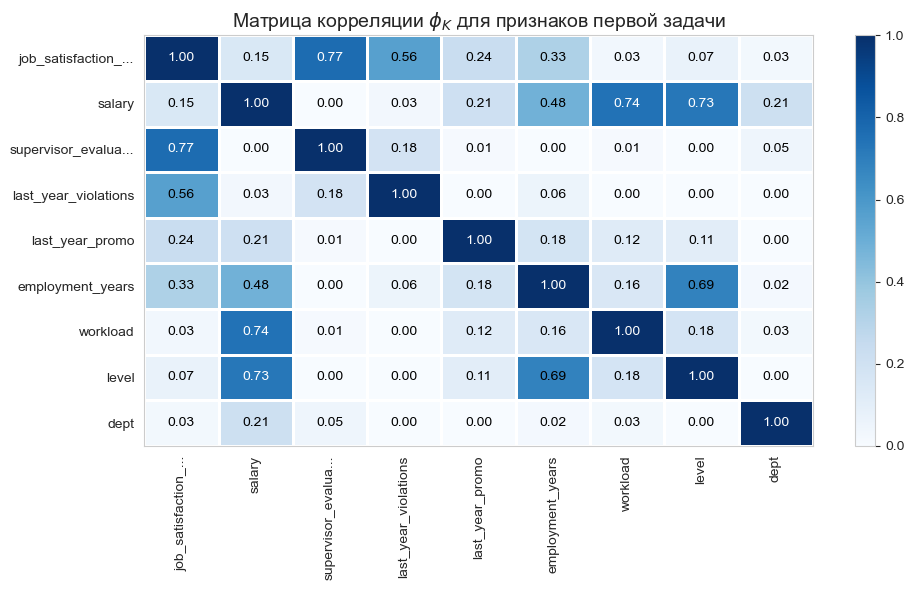

In [114]:
# построим матрицу корреляции для признаков первой задачи
plot_correlation_matrix(
    phik_overview_case_1.values,
    x_labels=phik_overview_case_1.columns,
    y_labels=phik_overview_case_1.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляции $\phi_K$ для признаков первой задачи',
    fontsize_factor=1,
    figsize=(10, 6)
) 

<font color='Darkblue'><i>Есть две пары входных признаков с высокой корреляцией:<br>- `salary`(зарплата) и `workload` (уровень загрузки) - 0.79<br>- `salary` и `level` (уровень занимаемой должности) - 0.73<br>При этом корреляция между признаками `workload` и `level` умеренная. Также слабая и корреляция всех трех признаков с целевым  `job_satisfaction_rate` (рейтиннг удовлетворённости работой). Поэтому пока не будем удалять ни один из входных признаков из данных для моделирования.<br>У целевого признака - `job_satisfaction_rate` - высокое значение корреляции только с одним входным признаком `supervisor_evaluation` (оценка руководителем сотрудника). Однако это не является "утечкой данных", поэтому мы также не будем удалять этот входной признак из данных для моделирования

In [116]:
# считаем корреляцию для признаков второй задачи
phik_overview_case_2 = phik_matrix(case_2.drop('id', axis=1), interval_cols=case_2_continuous_cols) 

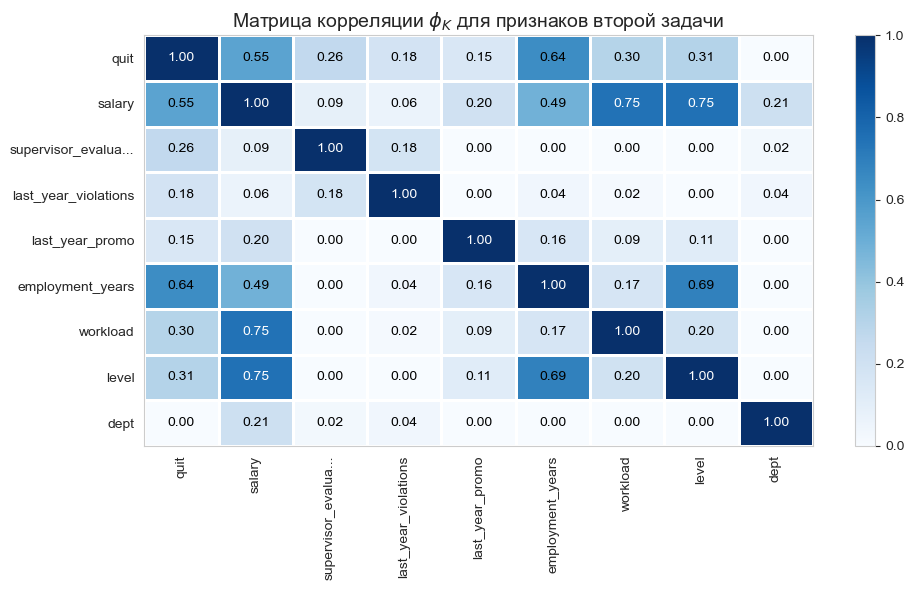

In [117]:
# построим матрицу корреляции для признаков первой задачи
plot_correlation_matrix(
    phik_overview_case_2.values,
    x_labels=phik_overview_case_2.columns,
    y_labels=phik_overview_case_2.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляции $\phi_K$ для признаков второй задачи',
    fontsize_factor=1,
    figsize=(10, 6)
) 

<font color='Darkblue'><i>Как и в данных для первой задачи выявлено две пары входных признаков с высокой корреляцией:<br>- `salary`(зарплата) и `workload` (уровень загрузки) - 0.79<br>- `salary` и `level` (уровень занимаемой должности) - 0.75<br>При этом корреляция между признаками`workload` и `level` умеренная. Корреляция всех трех признаков с целевым `quit` (увольнение сотрудника) также не высокая. Поэтому также пока не будем удалять ни один из входных признаков из данных для моделирования.<br>У целевого признака `quit` - высокой корреляции нет ни с одним из входных признаков, заметная корреляция наблюдается только с признаками `employment_years` (0.64) и `salary` (0.55)

### Резюме анализа данных

<font color='Darkblue'><b><i> ✔️ Анализ данных в разрезе выборок показал наличие различий в структуре данных о представленности департаментов, занимаемых доложностях и загруженности персонала в данных для второй задачи. </b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`dept`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном пердставители отделов `technolgy`(36.1%), `hr` (24.5%) и `purchase` (14.5%), <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном пердставители отделов `purchase` (40.1%), `technolgy`(22.6%) и `sales` (13.9%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; такой же дисбаланс и среди работающих в тренировочной и тестовой выборках<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`level`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном пердставители позиций `middle`(88.9%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном пердставители позиций `junior` (55.2%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; чуть менее выраженный дисбаланс и среди работающих в тренировочной и тестовой выборках: работает в тренировочной выборке больше  специалистов уровня `junior`(55.2%), в тестовой превалируют сотрудники уровня `middle` (55.2%)<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`workload`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном сотрудники с загрузкой `medium`(46.0%) и `low`(43.3%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном сотрудники с загрузкой `high` (44.7%) и `low`(42.0%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; такой же дисбаланс и среди работающих в тренировочной и тестовой выборках: работает в тренировочной выборке больше сотрудников с загрузкой `low`(56.8%), в тестовой превалируют сотрудники c загрузкой `high` (55.1%)<br>
<font color='Darkblue'><b><i>Такой дисбаланс входных признаков</b></i>, как показал следующий этап - определения модели прогнозирования, <b>не отразился негативно на модели.</b>  Однако если подобная тенденци изменения структуры входных признаков сохранится, необходимо обратить внимание Заказчика, на необходимость изменения тренировочного и тестового наборов данных и перенастройки модели.<br><br>
<font color='Darkblue'><b><i>✔️ Анализ обобщенных данных</b></i><br>
<font color='Darkblue'><b><i><u>1. Количественные показатели, характеризующие сотрудников</b></i></u>:<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b> a) непрерывные количественные признаки</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- <b>`job_satisfaction_rate`</b>(уровень удовлетворенности сотрудников работой в компании) - целевой признак первой задачи </b>- распределение бимодальное, т.к. наблюдается 2 пика (оценка около 0.35-0.4 и оценка около 0.65-0.7): 75% оценивают свою удовлетворённость в довольно широком диапазоне от 0.24 до 0.8, средняя и медианные оценки довольно близки по значению - 0.54 и 0.57 соответственно<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- <b>`salary`</b> (зарплата) - ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды): 75% сотрудников получают зарплату в диапазоне от 19,200 до 52,800, среднее и медианное значения зарплаты довольно близки по уровню: 33,973.4 и 30,000 соответственно. Анализ выбросов значений зарплаты, показал, что в датасете присутсвуют данные о высокооплачиваемых сотрудниках (зарплата более 75 тыс), занимающих позиции `senior` <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <i>Анализ зарплаты в разрезе целевого признака второй задачи `quit` (уволен/работает) показал, что зарплата уволившихся сотрудников в основном ниже (диапазон 15-25 тыс), чем работающих (диапазон 25-50 тыс)</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b> b) дискретные количественные признаки</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- <b>`employment_years`</b> (длительность работы в компании): наибольшая доля сотрудников проработала в компании 1-2 года, на графике четко видна тенеднция снижения количества сотрудников с ростом стажа в компании<br>&nbsp;&nbsp;&nbsp;<i>Анализ длительности работы в компании в разрезе статуса увольнения показывает, что наибольшая часть сотрудников, проработавших в компании 1 год - это уволившиеся сотрудники, их доля падает с ростом стажа работы в компании, со стажем более 3х лет среди уволившихся единицы</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- <b>`supervisor_evaluation`</b> (оценка качества работы сотрудника руководителем): самая частая оценка сотрудников (чуть более 40%) - 4, с самой низкой оценкой - 1, работает не более 5% сотрудников, с максимальной (5) - около 15%<br>&nbsp;&nbsp;&nbsp;<i>Самая частая оценка уволившихся сотрудников - 3

<font color='Darkblue'><b><i>2. Категорийные показатели, характеризующие сотрудников</b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- `dept`(отдел, в котором работает сотрудник) - всего представлено 5 отделов: 'sales', 'hr', 'technology', 'purchasing' и 'marketing', в данных больше всего сотрудников отдела 'sales' - 38%<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Увольняются и продолжают работать по отделам примерно в одинаковом соотношении с небольшим перевесом уволившихся из отделов `technolgy` и `hr`</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- `level`(уровень занимаемой должности) - три категории: 'junior', 'middle' и 'snior', преобладает уровень 'junior' - 47.8% <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>88% уволившихся занимали должность `middle`, 55% работающих в компании сотрудников работают в позиции `junior`</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- `workload` (уровень загрузки) - три категории: 'low', 'medium' и 'high', преобладает уровень 'medium' - 51.8% <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Увольняются почти в равной степени как с загрузкой `medium`, так и с загрузкой `low`, тогда как работают в основном сотрудники с загрузкой `low`</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- `last_year_promo` (наличие продвижения за последний год) - две категории: 'yes' и 'no', преобладают сотрудники без продвижения - 97.0%<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>B обеих подгруппах (уволившиеся/работающие) превалирует доля без продвижения, но среди уволившихся их 99.8%</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- `last_year_violations`(нарушения трудового договора за последний год) - две категории: 'yes' и 'no', преобладают сотрудники без нарушений - 86.3%<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Среди уволившихся сотрудников почти в два раза больше сотрудников, нарушивших трудовой договор, чем среди тех, кто продолжает работать в компании.

<font color='Darkblue'><b><i>3. Анализ взаимосвязи показателя уровня удовлетворённости работой и увольнения из компании</b></i> показал, что <br>&nbsp;&nbsp;&nbsp;- чем выше рейтинг удовлетворенности сотрудника работой в компании, тем выше плотность распределения для работающих сотрудников<br>&nbsp;&nbsp;&nbsp;- чем ниже рейтинг удовлетворенности, тем выше плотность распределения для уволившихся<br>&nbsp;&nbsp;&nbsp;- средний рейтинг уволившихся - 0.39, средний рейтинг работающих - 0.61

<font color='Darkblue'><b><i>4. Корреляционный анализ данных показал</b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;a) в данных для первой задачи есть две пары входных признаков с высокой корреляцией:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary`(зарплата) и `workload` (уровень загрузки) - 0.79<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary` и `level` (уровень занимаемой должности) - 0.73<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;При этом корреляция между признаками `workload` и `level` умеренная. Также слабая и корреляция всех трех признаков с целевым  `job_satisfaction_rate` (рейтиннг удовлетворённости работой). <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;У целевого признака - `job_satisfaction_rate` - высокое значение корреляции только с одним входным признаком `supervisior_evaluation` (оценка руководителем сотрудника)<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;b) в данных для второй задачи также есть две пары входных признаков с высокой корреляцией:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary`(зарплата) и `workload` (уровень загрузки) - 0.79<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary` и `level` (уровень занимаемой должности) - 0.75<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;При этом корреляция между признаками`workload` и `level` умеренная. Корреляция всех трех признаков с целевым `quit` (увольнение сотрудника) также не высокая. <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;У целевого признака `quit` - высокой корреляции нет ни с одним из входных признаков, заметная корреляция наблюдается только с признаками `employment_years` (0.64) и `salary` (0.55)

<font color='Darkblue'><b><i>5. Для дальнейшей подготовки данных необходимо отметить:</b></i><br>&nbsp;&nbsp;&nbsp; - количественные признаки `salary`, `supervisor_evaluation` и `employment_years` необходимо масштабировать<br>&nbsp;&nbsp;&nbsp; категорийные признаки `level` и `workload` целесообразно кодировать с помощью OrdinalEncoder <br>&nbsp;&nbsp;&nbsp; - категорийные признаки `dept`, `last_year_promo` и `last_year_violations` целесообразно кодировать с помощью OneHotEncoder<br>&nbsp;&nbsp;&nbsp; - целевой признак `job_satisfaction_rate` ввиду того, что он представлен непрерывными количественными данными кодированию не подлежит
<font color='Darkblue'>&nbsp;&nbsp;&nbsp; - целевой признак `quit` целесообразно кодировать с помощью LabelEncoder

## Задача предсказания уровня удовлетворённости сотрудника

### Определение набора данных

In [127]:
# Очистим от дубликатов данные тренировочной выборки без указания ID
train_s_dupl_clean = train_satisfaction.drop('id', axis=1).drop_duplicates()
train_s_dupl_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3755 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


In [128]:
test_data_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


In [129]:
# определяем константы
RANDOM_STATE = 77

# формируем тренировочную выбобрку входных данных и целевого признака
X_train_s = train_s_dupl_clean.drop('job_satisfaction_rate',  axis=1)
y_train_s = train_s_dupl_clean['job_satisfaction_rate']

# формируем тестовую выбобрку входных данных и целевого признака
X_test = test_data_satisfaction.drop(['id','job_satisfaction_rate'], axis=1)
y_test = test_data_satisfaction['job_satisfaction_rate']

print('Размер тренировочной выборки:', X_train_s.shape)
print('Количество данных целевого признака тренировочной выборки:', y_train_s.shape)
print('Перечень колонок тренировочной выборки\n', X_train_s.columns.to_list())
print('--'*60)
print('Размер тестовой выборки:', X_test.shape)
print('Количество данных целевого признака тестовой выборки:', y_test.shape)
print('Перечень колонок тестовой выборки\n', X_test.columns.to_list())

Размер тренировочной выборки: (3755, 8)
Количество данных целевого признака тренировочной выборки: (3755,)
Перечень колонок тренировочной выборки
 ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']
------------------------------------------------------------------------------------------------------------------------
Размер тестовой выборки: (2000, 8)
Количество данных целевого признака тестовой выборки: (2000,)
Перечень колонок тестовой выборки
 ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']


In [130]:
# создаём списки с названиями признаков для различных методов подготовки данных
num_columns = ['salary', 'supervisor_evaluation', 'employment_years']
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
# определим категории для признаков
levels = ['junior', 'middle', 'sinior']
w_load = ['low', 'medium', 'high']

### Создание пайплайнов для подготовки данных, определения лучшей комбинации модели и гиперпараметров

In [132]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
#SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression(n_jobs=-1))
    ])

In [133]:
# создаем параметры для перебора методов подготовки данных и поиска оптимальной модели 
param_grid = [
    # словарь для модели linearRegression()
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsRegression()
    { 
    'models': [KNeighborsRegressor()], 
        'models__n_neighbors': range(3, 6),  # Количество соседей для рассмотрения
        'models__weights': ['uniform', 'distance'], # Тип весов для соседей: однородные веса 
                                                    # (все точки в каждой окрестности имеют одинаковый вес) и вес точек обратно пропорционален их расстоянию
        'models__algorithm': ['auto', 'brute'],  # Алгоритм для поиска ближайших соседей (перебираем все и ищем оптимальное расстояние)
        'models__p': [1, 2],  # Параметр мощности для расстояния Минковского: перебираем оба варианта (манхэттенское и евклидово расстояние)
        'models__metric': ['euclidean', 'manhattan'],  # Метрика расстояния для вычисления ближайших соседей
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
     },
     # словарь для модели SVR()
    {
        'models': [SVR()],
        'models__kernel': ['rbf', 'linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

### Создание пользовательской метрики

<font color='Darkblue'><i>Для оценки качества модели будем использовать метрику SMAPE (symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). <b>Критерий успеха SMAPE <= 15 на тестовой выборке<b>

In [136]:
# создаём функцию для оценки качества модели
def custom_metric(y_true, y_pred):
    n = len(y_true)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.sum(numerator / denominator) * (100 / n)
    return smape

# создаём пользовательскую метрику
smape_score = make_scorer(custom_metric, greater_is_better=False) 

### Обучение и выбор наилучшей модели

In [138]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=50,
    cv=kf_cv,
    scoring=smape_score,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
random_search.fit(X_train_s, y_train_s)
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [139]:
print('Параметры лучшей модели:', random_search.best_params_)
print('--'*60)
print('Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных:', round(random_search.best_score_*(-1), 2))

Параметры лучшей модели: {'preprocessor__num': RobustScaler(), 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=77)}
------------------------------------------------------------------------------------------------------------------------
Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 16.09


In [140]:
y_test_predict_s = random_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {round(custom_metric(y_test, y_test_predict_s), 2)}')

Метрика SMAPE на тестовой выборке: 14.28


In [141]:
# Посмотрим на общие результаты поиска гиперпараметров
result_s = pd.DataFrame(random_search.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']]
result_s.mean_test_score = result_s.mean_test_score * -1
result_s = result_s.sort_values(by='rank_test_score')
# Конвертируем значения в столбце params в строки
result_s['params'] = result_s['params'].astype(str)
result_s.head(10)

,params,mean_test_score,rank_test_score
38,"{'preprocessor__num': RobustScaler(), 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=77)}",16.09,1
0,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=77)}",16.09,2
1,"{'preprocessor__num': StandardScaler(), 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=77)}",16.11,3
18,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=77)}",16.22,4
28,"{'preprocessor__num': 'passthrough', 'models__max_features': 10, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=77)}",16.26,5
49,"{'preprocessor__num': 'passthrough', 'models__max_features': 13, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=77)}",16.28,6
39,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 10, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=77)}",16.29,7
14,"{'preprocessor__num': RobustScaler(), 'models__max_features': 9, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=77)}",16.32,8
17,"{'preprocessor__num': RobustScaler(), 'models__weights': 'distance', 'models__p': 2, 'models__n_neighbors': 4, 'models__metric': 'euclidean', 'models__algorithm': 'auto', 'models': KNeighborsRegressor()}",16.51,9
10,"{'preprocessor__num': StandardScaler(), 'models__weights': 'distance', 'models__p': 2, 'models__n_neighbors': 3, 'models__metric': 'euclidean', 'models__algorithm': 'brute', 'models': KNeighborsRegressor()}",16.63,10


<font color='Darkblue'><i>✔ Из представленной выше таблицы видно, что в целом <b>высокий результат на тренировочной выборке дает модель DecisionTreeRegression (с параметрами 'max_features': 11 и 'max_depth': 12)</b>, разницу в рангах 1, 2 и 3 дает разный метод масштабирования количественного признака.<br>✔ Лучший результат на тренировочных данных дал <b>метод масштабирования - RobustScaler()<br>✔ Метрика SMAPE, рассчитанная на тестовой выборке показала значение 14.28 при целевом значнии SMAPE <=15.

### Проверка модели на адекватность

<font color='Darkblue'><i>Для проверки модели на адекватность используем классификатор DummyRegressor

In [145]:
dummy_reg = DummyRegressor()

dummy_reg.fit(X_train_s, y_train_s)

dummy_reg.predict(X_test)
dummy_reg_prediction = dummy_reg.predict(X_test)

# Рассчитываем и выводим метрику SMAPE
print(f'Метрика SMAPE для модели DummyRegressor: {round(custom_metric(y_test, dummy_reg_prediction), 2)}')


Метрика SMAPE для модели DummyRegressor: 38.26


<font color='Darkblue'><i><b>✔ Метрика SMAPE, рассчитанная для тестовых данных на основе базовой модели, существенно хуже, нежели таже метрика, рассчитанная на базе прогноза выбранной лучшей модели.

### Анализ важности признаков

In [148]:
#кодируем признаки выбранным наиболее подходящим кодировщиком
X_coded = random_search.best_estimator_['preprocessor'].transform(X_train_s)
# формируем список признаков
features_names = random_search.best_estimator_[:-1].get_feature_names_out()
# сформируем новый датафрейм с закодированными данными тренировочной выборки
X_train_coded = pd.DataFrame(X_coded, columns = features_names)

In [149]:
# для ускорения расчетов создаем masker (фоновые данные для обучения explainer) c 50 образцами
masker = shap.maskers.Independent(X_coded, max_samples=50)
# осуществим расчет значений SHAP
explainer = shap.Explainer(random_search.best_estimator_['models'].predict, masker=masker, feature_names=features_names)
explanation = explainer(X_coded)

PermutationExplainer explainer: 3756it [01:41, 37.04it/s]                          


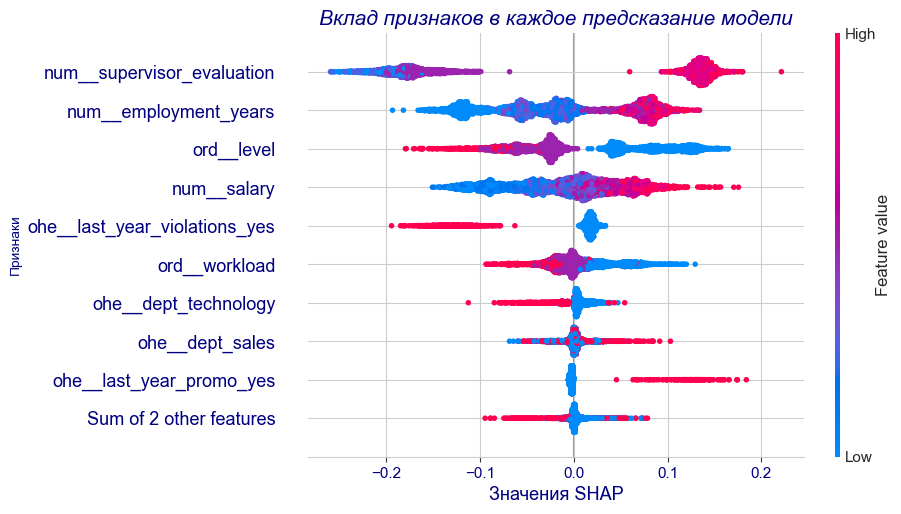

In [150]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 1, 1)
shap.plots.beeswarm(explanation, show=False)
plt.title('Вклад признаков в каждое предсказание модели', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()

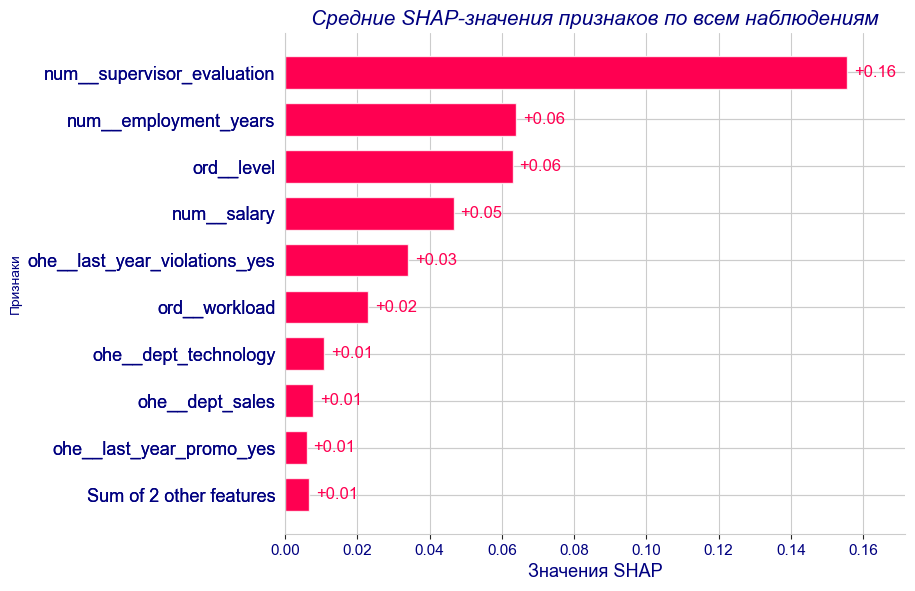

In [151]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
shap.plots.bar(explanation, show=False)
plt.title('Средние SHAP-значения признаков по всем наблюдениям', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()

<font color='Darkblue'><i>✔ Из приведенных выше графиков видно, что <b>наиболее значимым признаком в выбранной наилучшей модели, прогнозирующей уровень удовлетворённости сотрудника, является оценка качества работы сотрудника руководителем: чем выше оценка, тем выше удовлетворённость</b>б таже заметным влиянием обладают признаки длительности работы в компании и уровень занимаемой долности

### Резюме

<font color='Darkblue'>1) В результате подбора методом RandomizedSearchCV модели, ее гиперпараметров, а также методов нормализации количественных признаков <b>для прогнозирования уровня удовлетворённости сотрудников была определена наилучшая модель: DecisionTreeRegression (с параметрами 'max_features': 11 и 'max_depth': 12) и метод нормализации количественных признаков методом RobustScaler()</b><br>2) Пользовательская метрика SMAPE на тренировочной выборке составила 16.09, что свидетельствует о хорошей способности модели интерполировать уровень удовлетворённости сотрудников.<br>На <b>тестовой выборке метрика SMAPE составила 14.28</b>, что подтверждает достаточное качество выбранной модели для прогноза удовлетворённости сотрудников.<br>3) Проверка выбранной модели на адекватность, путем сравнения ее метрики с метрикой, сформированной на основе модели предсказания DummyRegressor (модель, которая предсказывает среднее из массива входных признаков), показала, что выбранная модель значительно превосходит базовую константную модель по метрике SMAPE: у DummyRegressor() SMAPE составил 38.26<br>4) Анализ влияния признаков на результаты прогоноза выбранной модели, показал, что наиболее значимым признаком является оценка руководителя (чем выше оценка, тем выше удовлетворённость), таже заметным влиянием обладают признаки длительности работы в компании и уровень занимаемой должности

## Задача предсказания увольнения сотрудника из компании

### Добавление нового входного признака

<font color='Darkblue'><i> С учетом того, что на этапе анализа данных была выявлена взаимосвязь уровня удовлетворенности работой `job_satisfaction_rate` и фактом увольнения сотрудника из компании `quit`, добавим `job_satisfaction_rate` к входным признакам данных для второй задачи.

In [158]:
# проверим набор данных тренировочной выборки для второй задачи
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [159]:
# добавим колонку в тренировочную выборку второй задачи
train_data_q = train_quit.drop('id', axis=1)
train_data_q['satisfaction_rate'] = random_search.predict(train_data_q.drop('quit', axis=1))
train_data_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   satisfaction_rate      4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 312.6+ KB


In [160]:
# проверим набор данных тестовой выборки для второй задачи
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB


In [161]:
# добавим колонку в тестовую выборку второй задачи
test_data_q = test_quit.drop('id', axis=1)
test_data_q['satisfaction_rate'] = random_search.predict(test_data_q.drop('quit', axis=1))
test_data_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   quit                   2000 non-null   object 
 9   satisfaction_rate      2000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 156.4+ KB


### Определение набора данных

In [163]:
# Посмотрим на количество дубликатов в тренировочной выборке без указания ID
train_data_q_dupl = train_data_q.duplicated().sum()
print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(train_data_q_dupl, train_data_q_dupl / train_data_q.shape[0]))

Выявлено 1,413 дубликатов записей, их количество составляет 35.33% от всех записей


<font color='Darkblue'><i> С учетом того, что дубликатов выявлено 35.% всех записей, их удаление может негативно сказаться на качестве модели, поэтому оставим их в данных до получения результатов.

In [165]:
# определяем константы
RANDOM_STATE = 77

# формируем тренировочную выбобрку входных данных и целевого признака
#X_train_q = train_data_q_dupl_clean.drop('quit',  axis=1)
#y_train_q = train_data_q_dupl_clean['quit']
X_train_q = train_data_q.drop('quit',  axis=1)
y_train_q = train_data_q['quit']

# формируем тестовую выбобрку входных данных и целевого признака
X_test_q = test_data_q.drop('quit', axis=1)
y_test_q = test_data_q['quit']

print('Размер тренировочной выборки:', X_train_q.shape)
print('Количество данных целевого признака тренировочной выборки:', y_train_q.shape)
print('Перечень колонок тренировочной выборки\n', X_train_q.columns.to_list())
print('--'*85)
print('Размер тестовой выборки:', X_test_q.shape)
print('Количество данных целевого признака тестовой выборки:', y_test_q.shape)
print('Перечень колонок тестовой выборки\n', X_test_q.columns.to_list())

Размер тренировочной выборки: (4000, 9)
Количество данных целевого признака тренировочной выборки: (4000,)
Перечень колонок тренировочной выборки
 ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'satisfaction_rate']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Размер тестовой выборки: (2000, 9)
Количество данных целевого признака тестовой выборки: (2000,)
Перечень колонок тестовой выборки
 ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'satisfaction_rate']


In [166]:
# создаём списки с названиями признаков для различных методов подготовки данных
# к количественным добавляется job_satisfaction
num_columns_satisf = ['salary', 'supervisor_evaluation', 'employment_years', 'satisfaction_rate']
# список категориальных признаков остается без изменений
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']

In [167]:
# кодирование целевого признака quit, т.к. он выражен строковыеми значениями
#создаем экземпляр класса LabelEncoder
label_encoder = LabelEncoder()
# обучаем и кодируем тренировочную выборку
y_train_q = label_encoder.fit_transform(y_train_q)
# кодируем тестовую выборку
y_test_q = label_encoder.transform(y_test_q)

In [168]:
# посмотрим какой класс присовен какому значению в целевом признаке
print("\nСоотношение значения и присвоенного кодировщиком класса:")
for cl, category in enumerate(label_encoder.classes_):
    print(f"- значению целевого признака quit (уволился из компании)'{category}' присвоен класс {cl}")


Соотношение значения и присвоенного кодировщиком класса:
- значению целевого признака quit (уволился из компании)'no' присвоен класс 0
- значению целевого признака quit (уволился из компании)'yes' присвоен класс 1


In [169]:
# определение параметра на кросс-валидации для несбалансированных выборок
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Создание пайплайнов для подготовки данных, определения лучшей комбинации модели и гиперпараметров

In [171]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
#SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns_satisf)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [172]:
#для перебора гиперпараметров моделей создадим список словарей,
# в котором каждый словарь — это модель с гиперпараметрами и методами подготовки данных

param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
] 

### Обучение и выбор наилучшей модели

<font color='Darkblue'><i>Как было выявлено раннее, в данных целевого параметра - увольнение из компании -  есть преобладание категории `no`, т.е. продолжает работать (71.8%), поэтому для оценки качества модели будем использовать метрику ROC_AUC, которая не зависит от дисбаланса классов и не зависит от значения порога отнесения к тому или иному классу.

In [175]:
# для подбора гиперпараметров будем использовать инструмент GridSearchCV, в котором 
grid = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv=stratified_cv,
    scoring='roc_auc', 
    n_jobs=-1
)
# обучим модель и посмотрим метрику на тренировочной выборке
grid.fit(X_train_q, y_train_q)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('-'*60)
print('Метрика ROC-AUC для лучшей модели:', round(grid.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [176]:
y_test_q_pred_proba = grid.predict_proba(X_test_q)[:, 1]
print('\nМетрика ROC-AUC на тестовой выборке', round(roc_auc_score(y_test_q, y_test_q_pred_proba), 2))


Метрика ROC-AUC на тестовой выборке 0.92


In [177]:
# Посмотрим на общие результаты поиска гиперпараметров
result_q = pd.DataFrame(grid.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']]
result_q.mean_test_score = result_q.mean_test_score
result_q = result_q.sort_values(by='rank_test_score')
# Конвертируем значения в столбце params в строки
result_q['params'] = result_q['params'].astype(str)
result_q.head(10)

,params,mean_test_score,rank_test_score
220,"{'models': DecisionTreeClassifier(random_state=77), 'models__max_depth': 6, 'models__max_features': 4, 'preprocessor__num': MinMaxScaler()}",0.93,1
221,"{'models': DecisionTreeClassifier(random_state=77), 'models__max_depth': 6, 'models__max_features': 4, 'preprocessor__num': 'passthrough'}",0.93,1
572,"{'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 2, 'preprocessor__num': 'passthrough'}",0.93,3
575,"{'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 3, 'preprocessor__num': 'passthrough'}",0.93,4
578,"{'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 4, 'preprocessor__num': 'passthrough'}",0.93,5
219,"{'models': DecisionTreeClassifier(random_state=77), 'models__max_depth': 6, 'models__max_features': 4, 'preprocessor__num': StandardScaler()}",0.93,6
571,"{'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 2, 'preprocessor__num': MinMaxScaler()}",0.93,7
577,"{'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 4, 'preprocessor__num': MinMaxScaler()}",0.93,8
569,"{'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 1, 'preprocessor__num': 'passthrough'}",0.93,9
576,"{'models': LogisticRegression(penalty='l1', random_state=77, solver='liblinear'), 'models__C': 4, 'preprocessor__num': StandardScaler()}",0.93,10


<font color='Darkblue'><i>✔ Из представленной выше таблицы видно, что в целом <b>высокий результат на тренировочной выборке дает модель LogisticRegression ()</b>, разницу в рангах 1, 2 и 3 дает разный метод масштабирования количественного признака.<br>✔ Лучший результат на тренировочных данных дал <b>метод масштабирования - StandardScaler()</b><br>✔<b> Метрика ROC-AUC, рассчитанная на тестовой выборке показала значение 0.92 при целевом значнии ROC-AUC => 0.93.

### Анализ важности признаков

In [180]:
#кодируем признаки выбранным наиболее подходящим кодировщиком
X_coded_q = grid.best_estimator_['preprocessor'].fit_transform(X_train_q)

# формируем список признаков
features_names_q = grid.best_estimator_[:-1].get_feature_names_out()
# сформируем новый датафрейм с закодированными данными тренировочной выборки
X_train_coded_q = pd.DataFrame(X_coded_q, columns = features_names_q)

In [181]:
# для ускорения расчетов создаем masker (фоновые данные для обучения explainer) c 50 образцами
masker = shap.maskers.Independent(X_coded_q, max_samples=50)
# осуществим расчет значений SHAP
explainer = shap.Explainer(grid.best_estimator_['models'].predict, masker=masker, feature_names=features_names_q)
explanation_q = explainer(X_coded_q)

PermutationExplainer explainer: 4001it [02:28, 25.75it/s]                          


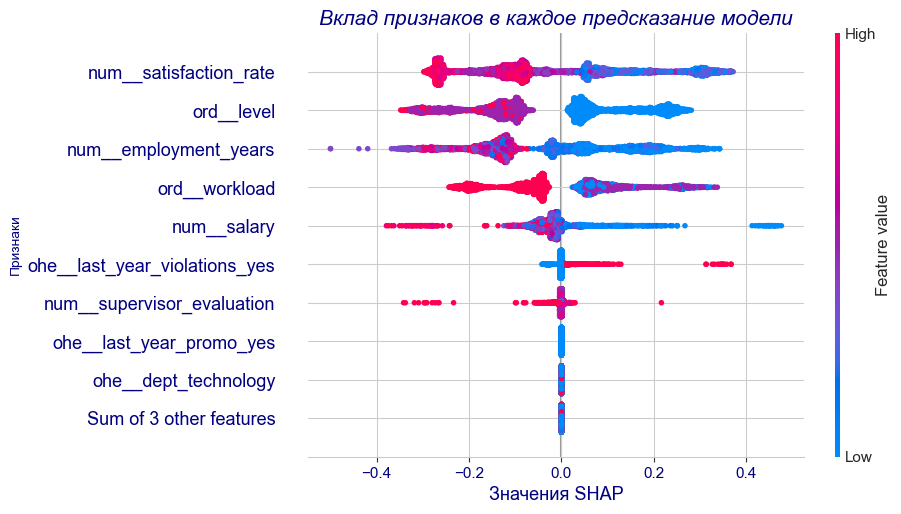

In [182]:
# строим график влияния признаков на предсказание модели
plt.figure(figsize=(18, 6))
plt.subplot(1, 1, 1)
shap.plots.beeswarm(explanation_q, show=False)
plt.title('Вклад признаков в каждое предсказание модели', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()

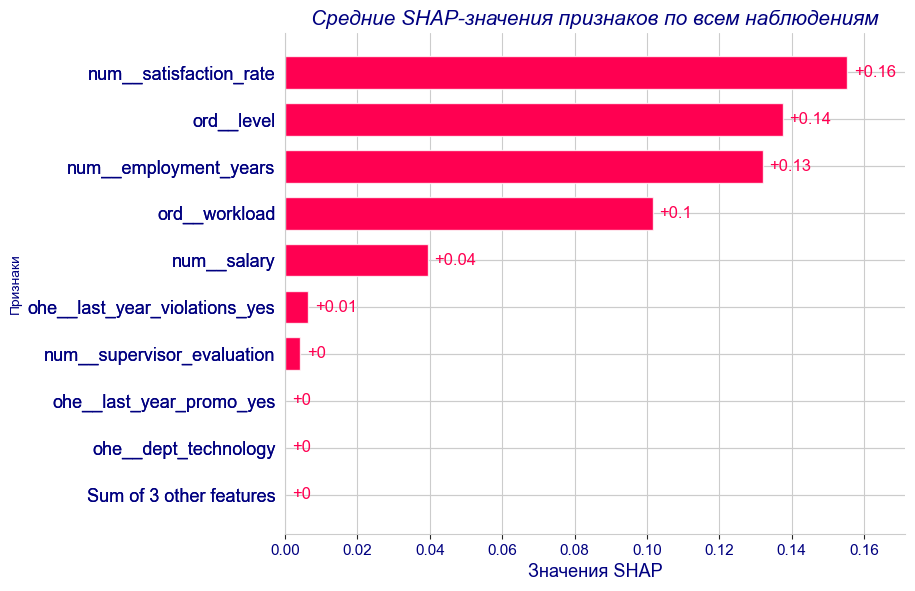

In [183]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
shap.plots.bar(explanation_q, show=False)
plt.title('Средние SHAP-значения признаков по всем наблюдениям', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()

<font color='Darkblue'><i>✔ Из приведенных выше графиков видно, что <b>наиболее значимым признаком в выбранной наилучшей модели, прогнозирующей увольнение сотрудника, является уровень удолетворённости сотрудника: чем выше его удовлетворённость, тем меньше вероятность его увольнения</b>.<br>✔ Следующими по уровню положительного влияния на продолжение работы в компании является количество отработанных сотрудником в компании лет и уровень занимаемой должности.<br>✔ Также существенный вклад (положительный - выше значение, меньше вероятность увольнения) в прогноз вероятности увольнения вносят уровень зарплаты и загрузка сотрудника

### Резюме

<font color='Darkblue'>1) В результате подбора методом GriddSearchCV модели, ее гиперпараметров, а также методов нормализации количественных признаков для прогнозирования уольнения сотрудников была определена <b>наилучшая модель: LogisticRegression ()</b> и метод нормализации количественных признаков методом StandardScaler()</b><br>2) Метрика ROC-AUC на тренировочной выборке составила 0.93, что свидетельствует о хорошей способности модели определять вероятность увольнения сотрудников.<br>На <b>тестовой выборке метрика ROC_AUC составила 0.92</b>, что подтверждает достаточное качество выбранной модели для прогноза вероятности увольнения сотрудников.<br>3) Анализ влияния признаков на результаты прогоноза выбранной модели, показал, что <br>&nbsp;&nbsp;&nbsp;<b>- наиболее значимым признаком в выбранной наилучшей модели, прогнозирующей увольнение сотрудника, является уровень удолетворённости сотрудника: чем выше его удовлетворённость, тем меньше вероятность его увольнения</b>.<br>&nbsp;&nbsp;&nbsp; - следующими по уровню положительного влияния на продолжение работы в компании является количество отработанных сотрудником в компании лет и уровень занимаемой должности<br>&nbsp;&nbsp;&nbsp; - также существенный вклад (положительный - выше значение, меньше вероятность увольнения) в прогноз вероятности увольнения вносят уровень зарплаты и загрузка сотрудника.

## Выводы

<font color='Darkblue'><b><u>I. Обзор предоставленных данных</b></u><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b><u>A.</b> Для исследования предоставлено 5 датасетов</u><br> &nbsp;&nbsp;&nbsp;<b>1) Датасет `train_satisfaction`</b> содержит 10 колонок 4000 записей тенировочной выборки данных о персонале<br> &nbsp;&nbsp;&nbsp;<b>2) Датасет `test_features`</b> тестовый набор данных о персонале, содержит 2000 записей<br> &nbsp;&nbsp;&nbsp;<b>3) Датасет `test_target_satisfaction`</b> тестовый набор данных содержит 2 колонки 2000 записей.<br> &nbsp;&nbsp;&nbsp;<b>4) Датасет `train_quit`</b> содержит 10 колонок 4000 записей<br> &nbsp;&nbsp;&nbsp;<b>5) Датасет `test_target_quit`</b> содержит 2 колонки 2000 записей<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;Все датасеты содержат - `id` — уникальный идентификатор сотрудника<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;Датасеты `train_satisfaction`, `train_quit` и `test_features` - содержат колонки <b>входных признаков:</b><br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `dept` — отдел, в котором работает сотрудник<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `level` — уровень занимаемой должности<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `work_load` — уровень загруженности сотрудника<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `employement_years` — длительность работы в компании (в годах)<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `last_year_promo` — показывает, было ли повышение за последний год<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `salary` — ежемесячная зарплата сотрудника<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;Датасеты `train_satisfaction` и `test_target_satisfaction` содержат колонки <b>целевого признака для первой задачи</b> - `job_satisfaction_rate` — уровень удовлeтворённости сотрудника работой в компании<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;Датасеты `train_quit` и `test_target_quit` содержат колонки <b>целевого признака для второй задачи</b> - `quit` — увольнение сотрудника из компании сотрудника из компании<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<u><b>B.</b> В рамках предподготовки данных</u><br>&nbsp;&nbsp;&nbsp; - изменен тип данных в колонке `job_satisfaction_rate` для тестовой и тренировочной выборок <br>&nbsp;&nbsp;&nbsp; - определены, но не удалены пропуски данных в колонках `dept`, `level` и `workload` - которые в дальнейшем при подготовке данных для модели заменены SimpleImputer на моду<br>

<font color='Darkblue'><b><u>II. Анализ данных данных</b></u><br><br>
<font color='Darkblue'><b><i>✔️ Анализ данных в разрезе выборок показал наличие различий в структуре данных о представленности департаментов, занимаемых доложностях и загруженности персонала в данных для второй задачи. </b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`dept`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном пердставители отделов `technolgy`(36.1%), `hr` (24.5%) и `purchase` (14.5%), <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном пердставители отделов `purchase` (40.1%), `technolgy`(22.6%) и `sales` (13.9%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; такой же дисбаланс и среди работающих в тренировочной и тестовой выборках<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`level`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном пердставители позиций `middle`(88.9%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном пердставители позиций `junior` (55.2%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; чуть менее выраженный дисбаланс и среди работающих в тренировочной и тестовой выборках: работает в тренировочной выборке больше  специалистов уровня `junior`(55.2%), в тестовой превалируют сотрудники уровня `middle` (55.2%)<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b>`workload`</b> <br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; в тренировочной выборке среди уволенных в основном сотрудники с загрузкой `medium`(46.0%) и `low`(43.3%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp;тогда как в тестовой -  среди уволенных в основном сотрудники с загрузкой `high` (44.7%) и `low`(42.0%)<br>&nbsp;&nbsp;&nbsp;>&nbsp;&nbsp;&nbsp; такой же дисбаланс и среди работающих в тренировочной и тестовой выборках: работает в тренировочной выборке больше сотрудников с загрузкой `low`(56.8%), в тестовой превалируют сотрудники c загрузкой `high` (55.1%)<br>
<font color='Darkblue'><b><i>Такой дисбаланс входных признаков</b></i>, как показал следующий этап - определения модели прогнозирования, <b>не отразился негативно на модели.</b>  Однако если подобная тенденци изменения структуры входных признаков сохранится, необходимо обратить внимание Заказчика, на необходимость изменения тренировочного и тестового наборов данных и перенастройки модели.<br><br>
<font color='Darkblue'><b><i>✔️ Анализ обощенных данных</b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b><i><u>1. Количественные показатели, характеризующие сотрудников</b></i></u>:<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b> a) непрерывные количественные признаки</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- <b>`job_satisfaction_rate`</b>(уровень удовлетворенности сотрудников работой в компании) - целевой признак первой задачи </b>- распределение бимодальное, т.к. наблюдается 2 пика (оценка около 0.35-0.4 и оценка около 0.65-0.7): 75% оценивают свою удовлетворённость в довольно широком диапазоне от 0.24 до 0.8, средняя и медианные оценки довольно близки по значению - 0.54 и 0.57 соответственно<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- <b>`salary`</b> (зарплата) - ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды): 75% сотрудников получают зарплату в диапазоне от 19,200 до 52,800, среднее и медианное значения зарплаты довольно близки по уровню: 33,973.4 и 30,000 соответственно. Анализ выбросов значений зарплаты, показал, что в датасете присутсвуют данные о высокооплачиваемых сотрудниках (зарплата более 75 тыс), занимающих позиции `senior` <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <i>Анализ зарплаты в разрезе целевого признака второй задачи `quit` (уволен/работает) показал, что зарплата уволившихся сотрудников в основном ниже (диапазон 15-25 тыс), чем работающих (диапазон 25-50 тыс)</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b> b) дискретные количественные признаки</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- <b>`employment_years`</b> (длительность работы в компании): наибольшая доля сотрудников проработала в компании 1-2 года, на графике четко видна тенеднция снижения количества сотрудников с ростом стажа в компании<br>&nbsp;&nbsp;&nbsp;<i>Анализ длительности работы в компании в разрезе статуса увольнения показывает, что наибольшая часть сотрудников, проработавших в компании 1 год - это уволившиеся сотрудники, их доля падает с ростом стажа работы в компании, со стажем более 3х лет среди уволившихся единицы</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- <b>`supervisor_evaluation`</b> (оценка качества работы сотрудника руководителем): самая частая оценка сотрудников (чуть более 40%) - 4, с самой низкой оценкой - 1, работает не более 5% сотрудников, с максимальной (5) - около 15%<br>&nbsp;&nbsp;&nbsp;<i>Самая частая оценка уволившихся сотрудников - 3<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b><i>2. Категорийные показатели, характеризующие сотрудников</b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `dept`(отдел, в котором работает сотрудник) - всего представлено 5 отделов: 'sales', 'hr', 'technology', 'purchasing' и 'marketing', в данных больше всего сотрудников отдела 'sales' - 38%<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Увольняются и продолжают работать по отделам примерно в одинаковом соотношении с небольшим перевесом уволившихся из отделов `technolgy` и `hr`</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `level`(уровень занимаемой должности) - три категории: 'junior', 'middle' и 'snior', преобладает уровень 'junior' - 47.8% <br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>88% уволившихся занимали должность `middle`, 55% работающих в компании сотрудников работают в позиции `junior`</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `workload` (уровень загрузки) - три категории: 'low', 'medium' и 'high', преобладает уровень 'medium' - 51.8% <br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Увольняются почти в равной степени как с загрузкой `medium`, так и с загрузкой `low`, тогда как работают в основном сотрудники с загрузкой `low`</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `last_year_promo` (наличие продвижения за последний год) - две категории: 'yes' и 'no', преобладают сотрудники без продвижения - 97.0%<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>B обеих подгруппах (уволившиеся/работающие) превалирует доля без продвижения, но среди уволившихся их 99.8%</i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `last_year_violations`(нарушения трудового договора за последний год) - две категории: 'yes' и 'no', преобладают сотрудники без нарушений - 86.3%<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Среди уволившихся сотрудников почти в два раза больше сотрудников, нарушивших трудовой договор, чем среди тех, кто продолжает работать в компании.<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b><i>3. Анализ взаимосвязи показателя уровня удовлетворённости работой и увольнения из компании</b></i> показал, что <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- чем выше рейтинг удовлетворенности сотрудника работой в компании, тем выше плотность распределения для работающих сотрудников<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- чем ниже рейтинг удовлетворенности, тем выше плотность распределения для уволившихся<br>&nbsp;&nbsp;&nbsp;- средний рейтинг уволившихся - 0.39, средний рейтинг работающих - 0.61<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<b><i>4. Корреляционный анализ данных показал</b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a) в данных для первой задачи есть две пары входных признаков с высокой корреляцией:<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary`(зарплата) и `workload` (уровень загрузки) - 0.79<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary` и `level` (уровень занимаемой должности) - 0.73<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;При этом корреляция между признаками `workload` и `level` умеренная. Также слабая и корреляция всех трех признаков с целевым  `job_satisfaction_rate` (рейтиннг удовлетворённости работой).<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;У целевого признака - `job_satisfaction_rate` - высокое значение корреляции только с одним входным признаком `supervisior_evaluation` (оценка руководителем сотрудника)<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b) в данных для второй задачи также есть две пары входных признаков с высокой корреляцией:<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary`(зарплата) и `workload` (уровень загрузки) - 0.79<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- `salary` и `level` (уровень занимаемой должности) - 0.75<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;При этом корреляция между признаками`workload` и `level` умеренная. Корреляция всех трех признаков с целевым `quit` (увольнение сотрудника) также не высокая.<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;У целевого признака `quit` - высокой корреляции нет ни с одним из входных признаков, заметная корреляция наблюдается только с признаками `employment_years` (0.64) и `salary` (0.55)

<font color='Darkblue'><b><u>III. Задача предсказания уровня удовлетворённости сотрудника</b></u><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;1. В результате подбора методом RandomizedSearchCV модели, ее гиперпараметров, а также методов нормализации количественных признаков <b>для прогнозирования уровня удовлетворённости сотрудников была определена наилучшая модель: DecisionTreeRegression (с параметрами 'max_features': 11 и 'max_depth': 12) и метод нормализации количественных признаков методом RobustScaler()</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;2. Пользовательская <b>метрика SMAPE на тренировочной выборке составила 16.09</b>, что свидетельствует о хорошей способности модели интерполировать уровень удовлетворённости сотрудников.<br>На <b>тестовой выборке метрика SMAPE составила 14.28</b>, что подтверждает достаточное качество выбранной модели для прогноза удовлетворённости сотрудников.<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;3. Проверка выбранной модели на адекватность, путем сравнения ее метрики с метрикой, сформированной на основе модели предсказания DummyRegressor, показала, что выбранная модель значительно превосходит базовую константную модель по метрике SMAPE: у DummyRegressor() SMAPE составил 38.26<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;4. Анализ влияния признаков на результаты прогноза выбранной модели, показал, что наиболее значимым признаком является оценка руководителя (чем выше оценка, тем выше удовлетворённость), таже заметным влиянием обладают признаки длительности работы в компании и уровень занимаемой должности

<font color='Darkblue'><b><u>IV. Задача предсказания увольнения сотрудника</b></u><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;1. В результате подбора методом GriddSearchCV модели, ее гиперпараметров, а также методов нормализации количественных признаков для прогнозирования увольнения сотрудников была определена <b>наилучшая модель: LogisticRegression ()</b> и метод нормализации количественных признаков методом StandardScaler()</b><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;2. Метрика ROC-AUC на тренировочной выборке составила 0.93, что свидетельствует о хорошей способности модели определять вероятность увольнения сотрудников.<br>На <b>тестовой выборке метрика ROC_AUC составила 0.92</b>, что подтверждает достаточное качество выбранной модели для прогноза вероятности увольнения сотрудников.<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;3. Анализ влияния признаков на результаты прогоноза выбранной модели, показал, что <br>&nbsp;&nbsp;&nbsp;<b>- наиболее значимым признаком в выбранной наилучшей модели, прогнозирующей увольнение сотрудника, является уровень удолетворённости сотрудника: чем выше его удовлетворённость, тем меньше вероятность его увольнения</b><br>&nbsp;&nbsp;&nbsp; - следующими по уровню положительного влияния на продолжение работы в компании является количество отработанных сотрудником в компании лет и уровень занимаемой должности<br>&nbsp;&nbsp;&nbsp; - также существенный вклад (положительный - выше значение, меньше вероятность увольнения) в прогноз вероятности увольнения вносят уровень зарплаты и загрузка сотрудника.

<font color='Darkblue'><b><u>V. Рекоммендации для бизнеса</b></u><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<i> В рамках анализа взаимосвязи показателей был подтвержден выскоий уровень взаимовлияния уровня удовлетворённости сотрудника и его увольнения. Анализ моделей, наилучшим образом прогнозирующих удовлетворённость сотрудника и вероятность его увольнения, показал, что существенное влияние на удовлетворённость оказывает оценка руководителя, на увольнение - стаж работы в компании.<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;<i>С учетом этого, <b>представляется целесообразным рекомендовать Заказчику</b>:<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>1) ревизовать систему оценки, убедиться в ее объективности и адекватности, при выявлении проблем - доработать<br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>2) разработать систему обучения персонала, учитывающую результаты оценки, которая позволит не только повысить объективную оценку персонала его руководителями, и как следствие его удовлетворенность, но и увеличить срок работы сотрудников